In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cat

import os, umap, optuna, lightgbm

from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier


# Changing default dir
os.chdir("/Users/pedroteche/Documents/GitHub/icr_kaggle/")

# Pandas options
pd.set_option("display.max_columns", 500)
# Plotting options
sns.set_style("darkgrid")
import warnings

warnings.filterwarnings("ignore")

/Users/pedroteche/miniconda3/envs/optuna/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pedroteche/miniconda3/envs/optuna/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pedroteche/miniconda3/envs/optuna/lib/python3.10/si

In [2]:
def competition_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # Implements the Evaluation equation with w_0 = w_1 = 1.
    # Calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # Calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # Calculate the average log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
    log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
    # return the (not further weighted) average of the averages
    return (log_loss_0 + log_loss_1) / 2

In [3]:
tb_train_full = pd.read_parquet("data/processed/tb_train_full.parquet")
tb_train_full["Class"] = tb_train_full["Class"].astype("category")
num_vars = list(tb_train_full.select_dtypes(include="number").columns)
cat_vars = ["EJ"]
greek_vars = ["Alpha", "Beta", "Gamma", "Delta"]
target_var = "Class"

# LightGBM for Greeks

In [5]:
greek_optim = dict()
for greek in greek_vars:
    print(f"Optimizing model for {greek}")

    def objective(trial):
        # Data prep
        le = LabelEncoder()
        le.fit(tb_train_full[greek])
        X = tb_train_full[num_vars + cat_vars]
        y = le.transform(tb_train_full[greek])


        # Numerical transforms
        num_imp = KNNImputer()
        sca = RobustScaler()
        num_pip = Pipeline([("num_imp", num_imp), ("sca", sca)])
        # Categorical transforms
        ohe = OneHotEncoder(drop="first")
        cat_pip = Pipeline([("ohe", ohe)])
        # Numerical + Categorical Transforms
        preprocessor = ColumnTransformer(
            [("num", num_pip, num_vars), ("cat", cat_pip, cat_vars)]
        )
        # Model stack
        n_estimators = trial.suggest_int("lgbm_n_estimators", 100, 5000)
        learning_rate = trial.suggest_float("lgbm_learning_rate", 0.0001, 0.5)
        num_leaves = trial.suggest_int("lgbm_num_leaves", 4, 1024)
        min_data_in_leaf = trial.suggest_int("lgbm_min_data_in_leaf", 10, 100)
        reg_alpha = trial.suggest_float("lgbm_reg_alpha", 0.0, 10)
        reg_lambda = trial.suggest_float("lgbm_reg_lambda", 0.0, 10)
        subsample = trial.suggest_float("lgbm_subsample", 0.2, 1)
        subsample_freq = trial.suggest_int("lgbm_subsample_freq", 1, 10)
        lgb_fit = lightgbm.LGBMClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_data_in_leaf=min_data_in_leaf,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            subsample=subsample,
            subsample_freq=subsample_freq,
            class_weight="balanced",
        )
        # Full pipeline
        model = Pipeline([("preprocessor", preprocessor), ("cat", lgb_fit)])

        # Full pipeline
        score = cross_val_score(model, X, y, n_jobs=-1, cv=7, scoring="f1_macro")
        ll = score.mean()
        return ll

    study = optuna.create_study(
        storage="sqlite:///db_optuna.sqlite3",  # Specify the storage URL here.
        study_name=f"lightgbm_f1_{greek}",
        direction="maximize",
        load_if_exists=True
    )
    study.optimize(objective, n_trials=500)
    greek_optim[greek] = study.best_params
    print(f"Best value: {study.best_value} (params: {study.best_params})")

In [7]:
greek_probs = []
for greek in greek_vars:
    study = optuna.create_study(
        storage="sqlite:///db_optuna.sqlite3",  # Specify the storage URL here.
        study_name=f"lightgbm_f1_{greek}",
        direction="maximize",
        load_if_exists=True,
    )
    hyper_dict = study.best_params
    print(f"Optimizing model for {greek}")
    # Data prep
    le = LabelEncoder()
    le.fit(tb_train_full[greek])
    X = tb_train_full[num_vars + cat_vars]
    y = le.transform(tb_train_full[greek])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=34
    )

    # Numerical transforms
    num_imp = KNNImputer()
    sca = RobustScaler()
    num_pip = Pipeline([("num_imp", num_imp), ("sca", sca)])
    # Categorical transforms
    ohe = OneHotEncoder(drop="first")
    cat_pip = Pipeline([("ohe", ohe)])
    # Numerical + Categorical Transforms
    preprocessor = ColumnTransformer(
        [("num", num_pip, num_vars), ("cat", cat_pip, cat_vars)]
    )
    # Model stack
    use_balancing = hyper_dict["lgbm_class_weight"]
    n_estimators = hyper_dict["lgbm_n_estimators"]
    learning_rate = hyper_dict["lgbm_learning_rate"]
    num_leaves = hyper_dict["lgbm_num_leaves"]
    min_data_in_leaf = hyper_dict["lgbm_min_data_in_leaf"]
    reg_alpha = hyper_dict["lgbm_reg_alpha"]
    reg_lambda = hyper_dict["lgbm_reg_lambda"]
    subsample = hyper_dict["lgbm_subsample"]
    subsample_freq = hyper_dict["lgbm_subsample_freq"]
    print(hyper_dict)
    lgb_fit = lightgbm.LGBMClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_data_in_leaf=min_data_in_leaf,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        subsample=subsample,
        subsample_freq=subsample_freq,
        class_weight="balanced",
        n_jobs=1,
    )
    # Full pipeline
    model = Pipeline([("preprocessor", preprocessor), ("cat", lgb_fit)])
    model.fit(
        X_train,
        y_train,
    )
    probs = model.predict_proba(tb_train_full[num_vars + cat_vars])[:, :-1]
    tb_greek = pd.DataFrame(
        probs,
        columns=[f"{greek}_prob_{i}" for i in range(probs.shape[1])],
        index=tb_train_full.index,
    )
    greek_probs.append(tb_greek)

[I 2023-05-20 10:32:24,357] Using an existing study with name 'lightgbm_f1_Alpha' instead of creating a new one.


Optimizing model for Alpha
{'lgbm_class_weight': 'balanced', 'lgbm_learning_rate': 0.35695003949301196, 'lgbm_min_data_in_leaf': 91, 'lgbm_n_estimators': 2622, 'lgbm_num_leaves': 55, 'lgbm_reg_alpha': 0.27244541957645624, 'lgbm_reg_lambda': 5.670195600335002, 'lgbm_subsample': 0.973337651149932, 'lgbm_subsample_freq': 7, 'lr_class_weight': 'balanced'}


[I 2023-05-20 10:32:25,113] Using an existing study with name 'lightgbm_f1_Beta' instead of creating a new one.


Optimizing model for Beta
{'lgbm_class_weight': 'balanced', 'lgbm_learning_rate': 0.2666614363375348, 'lgbm_min_data_in_leaf': 18, 'lgbm_n_estimators': 1949, 'lgbm_num_leaves': 862, 'lgbm_reg_alpha': 0.03768706458593385, 'lgbm_reg_lambda': 1.3930454743804397, 'lgbm_subsample': 0.5164376566166886, 'lgbm_subsample_freq': 1, 'lr_class_weight': 'balanced'}
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2023-05-20 10:32:25,976] Using an existing study with name 'lightgbm_f1_Gamma' instead of creating a new one.


Optimizing model for Gamma
{'lgbm_class_weight': 'balanced', 'lgbm_learning_rate': 0.20268395994987026, 'lgbm_min_data_in_leaf': 13, 'lgbm_n_estimators': 271, 'lgbm_num_leaves': 210, 'lgbm_reg_alpha': 2.619184797677158, 'lgbm_reg_lambda': 7.803399808704134, 'lgbm_subsample': 0.8769892794701872, 'lgbm_subsample_freq': 6, 'lr_class_weight': 'balanced'}
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2023-05-20 10:32:26,346] Using an existing study with name 'lightgbm_f1_Delta' instead of creating a new one.


Optimizing model for Delta
{'lgbm_class_weight': 'balanced', 'lgbm_learning_rate': 0.36391703990194235, 'lgbm_min_data_in_leaf': 96, 'lgbm_n_estimators': 1515, 'lgbm_num_leaves': 700, 'lgbm_reg_alpha': 1.0141859157129727, 'lgbm_reg_lambda': 4.338070495539421, 'lgbm_subsample': 0.7459387514385107, 'lgbm_subsample_freq': 1, 'lr_class_weight': None}
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


# Joining the Greek models outputs

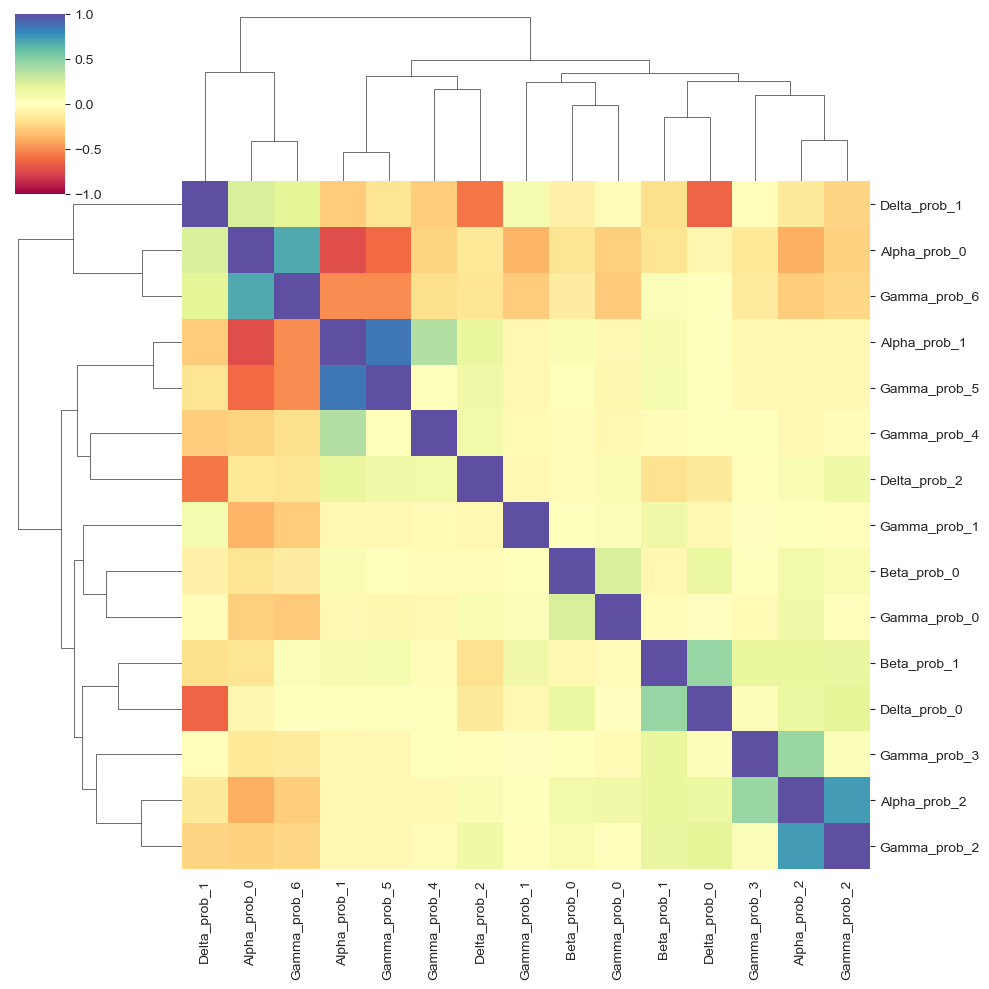

In [8]:
tb_greeks = pd.concat(greek_probs, axis=1)
greek_prob_vars = list(tb_greeks.columns)
sns.clustermap(
    tb_greeks.corr(numeric_only=True), vmin=-1, vmax=1, center=0, cmap="Spectral"
)
tb_full_greekp = pd.concat([tb_greeks, tb_train_full], axis=1)

# LightGBM for Full Model

In [10]:
def p_logloss_scorer(estimator, X, y):
    y_pred = estimator.predict_proba(X)[:, 1]
    return competition_log_loss(y.astype(int), y_pred)

In [13]:
def objective(trial):
    # Data prep
    X = tb_full_greekp[greek_prob_vars + num_vars]
    y = tb_full_greekp[target_var]

    # Numerical transforms
    num_imp = KNNImputer()
    sca = RobustScaler()
    # Model stack
    balanced = trial.suggest_categorical("lgbm_class_weight", ["balanced", None])
    n_estimators = trial.suggest_int("lgbm_n_estimators", 100, 5000)
    learning_rate = trial.suggest_float("lgbm_learning_rate", 0.0001, 0.5)
    num_leaves = trial.suggest_int("lgbm_num_leaves", 4, 1024)
    min_data_in_leaf = trial.suggest_int("lgbm_min_data_in_leaf", 10, 100)
    reg_alpha = trial.suggest_float("lgbm_reg_alpha", 0.0, 10)
    reg_lambda = trial.suggest_float("lgbm_reg_lambda", 0.0, 10)
    subsample = trial.suggest_float("lgbm_subsample", 0.2, 1)
    subsample_freq = trial.suggest_int("lgbm_subsample_freq", 1, 10)
    lgb_fit = lightgbm.LGBMClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_data_in_leaf=min_data_in_leaf,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        subsample=subsample,
        subsample_freq=subsample_freq,
        class_weight=balanced,
    )
    # Full pipeline
    model = Pipeline([("imputer", num_imp), ("sca", sca), ("cat", lgb_fit)])

    # Scoring
    score = cross_val_score(model, X, y, n_jobs=-1, cv=7, scoring=p_logloss_scorer)
    ll = score.mean()
    return ll


study = optuna.create_study(
    storage="sqlite:///db_optuna.sqlite3",  # Specify the storage URL here.
    study_name=f"lightgbm_bll_full",
    direction="minimize",
    load_if_exists=True,
)
study.optimize(objective, n_trials=500)

[I 2023-05-20 11:13:35,391] A new study created in RDB with name: lightgbm_bll_full


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:13:35,806] Trial 0 finished with value: 0.9675866027868298 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 3749, 'lgbm_learning_rate': 0.07735077591878659, 'lgbm_num_leaves': 281, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 7.881895794270375, 'lgbm_reg_lambda': 2.7086135560438294, 'lgbm_subsample': 0.24113525831109267, 'lgbm_subsample_freq': 9}. Best is trial 0 with value: 0.9675866027868298.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:13:36,196] Trial 1 finished with value: 0.25377389590574834 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 2325, 'lgbm_learning_rate': 0.09886250397925737, 'lgbm_num_leaves': 765, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 4.416886077176363, 'lgbm_reg_lambda': 2.861358421419533, 'lgbm_subsample': 0.31114420002884535, 'lgbm_subsample_freq': 3}. Best is trial 1 with value: 0.25377389590574834.
[I 2023-05-20 11:13:36,381] Trial 2 finished with value: 0.28145972660333507 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 157, 'lgbm_learning_rate': 0.24776686484120083, 'lgbm_num_leaves': 242, 'lgbm_min_data_in_leaf': 55, 'lgbm_reg_alpha': 0.2654090140801457, 'lgbm_reg_lambda': 9.26412640874119, 'lgbm_subsample': 0.48119854048090493, 'lgbm_subsample_freq': 8}. Best is trial 1 with value: 0.25377389590574834.


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min

[I 2023-05-20 11:13:37,094] Trial 3 finished with value: 0.2788109702122001 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 3407, 'lgbm_learning_rate': 0.261436396822708, 'lgbm_num_leaves': 734, 'lgbm_min_data_in_leaf': 14, 'lgbm_reg_alpha': 6.079594022543341, 'lgbm_reg_lambda': 9.82471105955793, 'lgbm_subsample': 0.8780588015299038, 'lgbm_subsample_freq': 2}. Best is trial 1 with value: 0.25377389590574834.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2023-05-20 11:13:37,527] Trial 4 finished with value: 0.2899063215580392 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 2569, 'lgbm_learning_rate': 0.3819492114542576, 'lgbm_num_leaves': 144, 'lgbm_min_data_in_leaf': 28, 'lgbm_reg_alpha': 3.6335058227020864, 'lgbm_reg_lambda': 2.725857854762521, 'lgbm_subsample': 0.8553423483363518, 'lgbm_subsample_freq': 7}. Best is trial 1 with value: 0.25377389590574834.


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


[I 2023-05-20 11:13:37,885] Trial 5 finished with value: 0.29427255195775015 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 491, 'lgbm_learning_rate': 0.2755579199128676, 'lgbm_num_leaves': 777, 'lgbm_min_data_in_leaf': 55, 'lgbm_reg_alpha': 1.342852489105052, 'lgbm_reg_lambda': 8.22574748174684, 'lgbm_subsample': 0.587601434955258, 'lgbm_subsample_freq': 4}. Best is trial 1 with value: 0.25377389590574834.
[I 2023-05-20 11:13:38,105] Trial 6 finished with value: 0.28054854677149327 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 477, 'lgbm_learning_rate': 0.4873590099649696, 'lgbm_num_leaves': 135, 'lgbm_min_data_in_leaf': 36, 'lgbm_reg_alpha': 2.6071658144983054, 'lgbm_reg_lambda': 1.5120655067027988, 'lgbm_subsample': 0.9415705140091848, 'lgbm_subsample_freq': 4}. Best is trial 1 with value: 0.25377389590574834.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min

[I 2023-05-20 11:13:38,702] Trial 7 finished with value: 0.2208770678210417 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 3488, 'lgbm_learning_rate': 0.18882740916859903, 'lgbm_num_leaves': 539, 'lgbm_min_data_in_leaf': 83, 'lgbm_reg_alpha': 7.946868022485427, 'lgbm_reg_lambda': 9.61669189321909, 'lgbm_subsample': 0.4323667082678048, 'lgbm_subsample_freq': 10}. Best is trial 7 with value: 0.2208770678210417.


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


[I 2023-05-20 11:13:39,194] Trial 8 finished with value: 0.24886314741194412 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 3831, 'lgbm_learning_rate': 0.3425942672827795, 'lgbm_num_leaves': 1017, 'lgbm_min_data_in_leaf': 68, 'lgbm_reg_alpha': 5.4580951400771305, 'lgbm_reg_lambda': 6.926498437413459, 'lgbm_subsample': 0.20608365511335133, 'lgbm_subsample_freq': 4}. Best is trial 7 with value: 0.2208770678210417.


[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62


[I 2023-05-20 11:13:39,541] Trial 9 finished with value: 0.21643777898856875 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1228, 'lgbm_learning_rate': 0.22129624804332307, 'lgbm_num_leaves': 715, 'lgbm_min_data_in_leaf': 62, 'lgbm_reg_alpha': 6.1803942733543495, 'lgbm_reg_lambda': 0.2987723495215122, 'lgbm_subsample': 0.3226689672717391, 'lgbm_subsample_freq': 5}. Best is trial 9 with value: 0.21643777898856875.


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


[I 2023-05-20 11:13:40,113] Trial 10 finished with value: 0.2084389699014532 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1628, 'lgbm_learning_rate': 0.026515320852948304, 'lgbm_num_leaves': 444, 'lgbm_min_data_in_leaf': 71, 'lgbm_reg_alpha': 9.451795042340937, 'lgbm_reg_lambda': 0.33497179127257287, 'lgbm_subsample': 0.7240394980006242, 'lgbm_subsample_freq': 6}. Best is trial 10 with value: 0.2084389699014532.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


[I 2023-05-20 11:13:40,601] Trial 11 finished with value: 0.21043906202676452 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1502, 'lgbm_learning_rate': 0.026303537485352954, 'lgbm_num_leaves': 466, 'lgbm_min_data_in_leaf': 72, 'lgbm_reg_alpha': 9.29978751779892, 'lgbm_reg_lambda': 0.13316205875278908, 'lgbm_subsample': 0.7139438694515452, 'lgbm_subsample_freq': 6}. Best is trial 10 with value: 0.2084389699014532.


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75


[I 2023-05-20 11:13:41,205] Trial 12 finished with value: 0.21508516748919618 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1863, 'lgbm_learning_rate': 0.007075838521842761, 'lgbm_num_leaves': 436, 'lgbm_min_data_in_leaf': 75, 'lgbm_reg_alpha': 9.878807430996218, 'lgbm_reg_lambda': 0.026125331689588194, 'lgbm_subsample': 0.7348287885570223, 'lgbm_subsample_freq': 6}. Best is trial 10 with value: 0.2084389699014532.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


[I 2023-05-20 11:13:43,473] Trial 13 finished with value: 0.24660340322145394 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4950, 'lgbm_learning_rate': 0.0007071915407939888, 'lgbm_num_leaves': 468, 'lgbm_min_data_in_leaf': 44, 'lgbm_reg_alpha': 9.791822190583996, 'lgbm_reg_lambda': 4.66182868811197, 'lgbm_subsample': 0.7203539297419529, 'lgbm_subsample_freq': 7}. Best is trial 10 with value: 0.2084389699014532.


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


[I 2023-05-20 11:13:44,163] Trial 14 finished with value: 0.21539212901949065 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1410, 'lgbm_learning_rate': 0.1201688312182692, 'lgbm_num_leaves': 344, 'lgbm_min_data_in_leaf': 76, 'lgbm_reg_alpha': 8.601620078950381, 'lgbm_reg_lambda': 1.0196952444875178, 'lgbm_subsample': 0.7198783029664186, 'lgbm_subsample_freq': 6}. Best is trial 10 with value: 0.2084389699014532.


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85


[I 2023-05-20 11:13:45,287] Trial 15 finished with value: 0.19611686331799122 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1360, 'lgbm_learning_rate': 0.055191777426458574, 'lgbm_num_leaves': 582, 'lgbm_min_data_in_leaf': 85, 'lgbm_reg_alpha': 6.812720298175828, 'lgbm_reg_lambda': 1.4391818602051019, 'lgbm_subsample': 0.6065117909519462, 'lgbm_subsample_freq': 8}. Best is trial 15 with value: 0.19611686331799122.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


[I 2023-05-20 11:13:45,986] Trial 16 finished with value: 0.20569412416041208 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2517, 'lgbm_learning_rate': 0.14804905491475365, 'lgbm_num_leaves': 604, 'lgbm_min_data_in_leaf': 87, 'lgbm_reg_alpha': 7.158020737088107, 'lgbm_reg_lambda': 1.7798689770355425, 'lgbm_subsample': 0.5745481221141862, 'lgbm_subsample_freq': 8}. Best is trial 15 with value: 0.19611686331799122.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2023-05-20 11:13:46,681] Trial 17 finished with value: 0.19947274265554363 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2758, 'lgbm_learning_rate': 0.1559745319078182, 'lgbm_num_leaves': 594, 'lgbm_min_data_in_leaf': 99, 'lgbm_reg_alpha': 7.134060620179746, 'lgbm_reg_lambda': 4.359990370268846, 'lgbm_subsample': 0.579446488953554, 'lgbm_subsample_freq': 10}. Best is trial 15 with value: 0.19611686331799122.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:13:47,427] Trial 18 finished with value: 0.19989806897994641 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 3006, 'lgbm_learning_rate': 0.15859624017040336, 'lgbm_num_leaves': 927, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 6.767870091258306, 'lgbm_reg_lambda': 4.510233701742262, 'lgbm_subsample': 0.4835965478276468, 'lgbm_subsample_freq': 10}. Best is trial 15 with value: 0.19611686331799122.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


[I 2023-05-20 11:13:48,332] Trial 19 finished with value: 0.19412136138590425 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4527, 'lgbm_learning_rate': 0.07585436759423449, 'lgbm_num_leaves': 605, 'lgbm_min_data_in_leaf': 84, 'lgbm_reg_alpha': 5.039089017351888, 'lgbm_reg_lambda': 5.514255476597359, 'lgbm_subsample': 0.6285546465949865, 'lgbm_subsample_freq': 9}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85


[I 2023-05-20 11:13:48,941] Trial 20 finished with value: 0.195503038008559 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4898, 'lgbm_learning_rate': 0.07985741568178956, 'lgbm_num_leaves': 30, 'lgbm_min_data_in_leaf': 85, 'lgbm_reg_alpha': 5.28510760079576, 'lgbm_reg_lambda': 5.767915800327508, 'lgbm_subsample': 0.6428664562799858, 'lgbm_subsample_freq': 8}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


[I 2023-05-20 11:13:49,726] Trial 21 finished with value: 0.194535040252467 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4923, 'lgbm_learning_rate': 0.06989606650394964, 'lgbm_num_leaves': 625, 'lgbm_min_data_in_leaf': 83, 'lgbm_reg_alpha': 4.882214083105623, 'lgbm_reg_lambda': 5.905717403177306, 'lgbm_subsample': 0.6405108667309917, 'lgbm_subsample_freq': 8}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


[I 2023-05-20 11:13:50,449] Trial 22 finished with value: 0.20543983128029217 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4896, 'lgbm_learning_rate': 0.0807189445786224, 'lgbm_num_leaves': 30, 'lgbm_min_data_in_leaf': 82, 'lgbm_reg_alpha': 4.958583553416969, 'lgbm_reg_lambda': 6.034651287002418, 'lgbm_subsample': 0.6557926909833122, 'lgbm_subsample_freq': 9}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:13:51,354] Trial 23 finished with value: 0.2063182246616186 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4316, 'lgbm_learning_rate': 0.06364334550165301, 'lgbm_num_leaves': 870, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 4.05647007284585, 'lgbm_reg_lambda': 5.692849283901623, 'lgbm_subsample': 0.8036222471034764, 'lgbm_subsample_freq': 9}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65


[I 2023-05-20 11:13:52,125] Trial 24 finished with value: 0.20853063367233604 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4398, 'lgbm_learning_rate': 0.11984037026879414, 'lgbm_num_leaves': 648, 'lgbm_min_data_in_leaf': 65, 'lgbm_reg_alpha': 5.221003431481989, 'lgbm_reg_lambda': 6.834542535651881, 'lgbm_subsample': 0.6412360698386999, 'lgbm_subsample_freq': 7}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


[I 2023-05-20 11:13:52,902] Trial 25 finished with value: 0.20977640681494264 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4513, 'lgbm_learning_rate': 0.04736048186585018, 'lgbm_num_leaves': 347, 'lgbm_min_data_in_leaf': 81, 'lgbm_reg_alpha': 3.752416290143232, 'lgbm_reg_lambda': 5.5499238629137295, 'lgbm_subsample': 0.5292449360815781, 'lgbm_subsample_freq': 8}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


[I 2023-05-20 11:13:53,632] Trial 26 finished with value: 0.20315570001783914 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4234, 'lgbm_learning_rate': 0.09906932739035873, 'lgbm_num_leaves': 837, 'lgbm_min_data_in_leaf': 78, 'lgbm_reg_alpha': 4.6976749273875935, 'lgbm_reg_lambda': 3.7659785705516033, 'lgbm_subsample': 0.6546431112070907, 'lgbm_subsample_freq': 9}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2023-05-20 11:13:54,549] Trial 27 finished with value: 0.20994216898988022 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4719, 'lgbm_learning_rate': 0.04387525495344062, 'lgbm_num_leaves': 671, 'lgbm_min_data_in_leaf': 60, 'lgbm_reg_alpha': 5.7509162267291805, 'lgbm_reg_lambda': 6.56283755716904, 'lgbm_subsample': 0.812903881853458, 'lgbm_subsample_freq': 7}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


[I 2023-05-20 11:13:55,276] Trial 28 finished with value: 0.2195433141992054 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4024, 'lgbm_learning_rate': 0.12003261094114114, 'lgbm_num_leaves': 56, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 3.10410870170982, 'lgbm_reg_lambda': 7.412464781398805, 'lgbm_subsample': 0.5272384472359103, 'lgbm_subsample_freq': 9}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:13:56,323] Trial 29 finished with value: 0.19881262337994995 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 3601, 'lgbm_learning_rate': 0.07906497536038139, 'lgbm_num_leaves': 362, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 4.820560365040912, 'lgbm_reg_lambda': 5.29200274217472, 'lgbm_subsample': 0.6597723998894816, 'lgbm_subsample_freq': 8}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53


[I 2023-05-20 11:13:57,236] Trial 30 finished with value: 0.20726358735323697 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4670, 'lgbm_learning_rate': 0.07293723479620873, 'lgbm_num_leaves': 282, 'lgbm_min_data_in_leaf': 53, 'lgbm_reg_alpha': 6.0009227009110555, 'lgbm_reg_lambda': 5.154647440163437, 'lgbm_subsample': 0.7732455619861501, 'lgbm_subsample_freq': 1}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2023-05-20 11:13:58,099] Trial 31 finished with value: 0.20084525195176742 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4095, 'lgbm_learning_rate': 0.04720381457923424, 'lgbm_num_leaves': 570, 'lgbm_min_data_in_leaf': 86, 'lgbm_reg_alpha': 5.358141086166345, 'lgbm_reg_lambda': 6.202221654606037, 'lgbm_subsample': 0.6077218912421648, 'lgbm_subsample_freq': 8}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:13:58,783] Trial 32 finished with value: 0.19948950512898883 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 3165, 'lgbm_learning_rate': 0.09460577883756079, 'lgbm_num_leaves': 515, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 6.60049428816683, 'lgbm_reg_lambda': 3.5533532718848178, 'lgbm_subsample': 0.6778123729778536, 'lgbm_subsample_freq': 9}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2023-05-20 11:13:59,319] Trial 33 finished with value: 0.20340112962307935 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1973, 'lgbm_learning_rate': 0.05585945750115431, 'lgbm_num_leaves': 641, 'lgbm_min_data_in_leaf': 86, 'lgbm_reg_alpha': 4.346528391633442, 'lgbm_reg_lambda': 4.858387289428788, 'lgbm_subsample': 0.6042879983615238, 'lgbm_subsample_freq': 8}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79


[I 2023-05-20 11:14:01,073] Trial 34 finished with value: 0.26956057153058444 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 4646, 'lgbm_learning_rate': 0.008890776713514986, 'lgbm_num_leaves': 706, 'lgbm_min_data_in_leaf': 79, 'lgbm_reg_alpha': 5.533785782472869, 'lgbm_reg_lambda': 5.907299521808836, 'lgbm_subsample': 0.6292611378215321, 'lgbm_subsample_freq': 10}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


[I 2023-05-20 11:14:01,457] Trial 35 finished with value: 0.26037264207039257 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 1028, 'lgbm_learning_rate': 0.09636129149648104, 'lgbm_num_leaves': 796, 'lgbm_min_data_in_leaf': 71, 'lgbm_reg_alpha': 4.358312057290114, 'lgbm_reg_lambda': 4.080279470951044, 'lgbm_subsample': 0.6959542611098858, 'lgbm_subsample_freq': 7}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:14:03,000] Trial 36 finished with value: 0.20572994244340653 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4999, 'lgbm_learning_rate': 0.04072258783593642, 'lgbm_num_leaves': 549, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 6.266829083146147, 'lgbm_reg_lambda': 3.1952048720318906, 'lgbm_subsample': 0.5592943076339255, 'lgbm_subsample_freq': 9}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2023-05-20 11:14:03,683] Trial 37 finished with value: 0.2733186906603499 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 3866, 'lgbm_learning_rate': 0.06975336716384704, 'lgbm_num_leaves': 247, 'lgbm_min_data_in_leaf': 20, 'lgbm_reg_alpha': 4.777472926564445, 'lgbm_reg_lambda': 2.467687669538861, 'lgbm_subsample': 0.7663226595067677, 'lgbm_subsample_freq': 5}. Best is trial 19 with value: 0.19412136138590425.
[I 2023-05-20 11:14:03,921] Trial 38 finished with value: 0.21296057771217636 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 896, 'lgbm_learning_rate': 0.19628146436177862, 'lgbm_num_leaves': 194, 'lgbm_min_data_in_leaf': 48, 'lgbm_reg_alpha': 5.707657877335711, 'lgbm_reg_lambda': 5.185041137265439, 'lgbm_subsample': 0.6224210890641565, 'lgbm_subsample_freq': 8}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min

[I 2023-05-20 11:14:04,434] Trial 39 finished with value: 0.25230712397158 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 2043, 'lgbm_learning_rate': 0.13219148151603932, 'lgbm_num_leaves': 394, 'lgbm_min_data_in_leaf': 84, 'lgbm_reg_alpha': 3.2473063785219227, 'lgbm_reg_lambda': 7.54196523510174, 'lgbm_subsample': 0.6797294610376893, 'lgbm_subsample_freq': 7}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66


[I 2023-05-20 11:14:04,731] Trial 40 finished with value: 0.21134258729482425 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 416, 'lgbm_learning_rate': 0.0943680556032119, 'lgbm_num_leaves': 751, 'lgbm_min_data_in_leaf': 66, 'lgbm_reg_alpha': 7.853488997400233, 'lgbm_reg_lambda': 4.045220993912975, 'lgbm_subsample': 0.46331014891151556, 'lgbm_subsample_freq': 10}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2023-05-20 11:14:05,253] Trial 41 finished with value: 0.19918707780055447 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 3398, 'lgbm_learning_rate': 0.06826373954480061, 'lgbm_num_leaves': 111, 'lgbm_min_data_in_leaf': 89, 'lgbm_reg_alpha': 4.880909363161351, 'lgbm_reg_lambda': 5.357982064428054, 'lgbm_subsample': 0.6384564608607203, 'lgbm_subsample_freq': 8}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:14:06,929] Trial 42 finished with value: 0.20050254899873374 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 3496, 'lgbm_learning_rate': 0.027583699869776136, 'lgbm_num_leaves': 506, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 5.109145739851026, 'lgbm_reg_lambda': 4.909989246484769, 'lgbm_subsample': 0.6784004087953771, 'lgbm_subsample_freq': 8}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:14:08,966] Trial 43 finished with value: 0.21224427320526287 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 3702, 'lgbm_learning_rate': 0.08422089651450927, 'lgbm_num_leaves': 626, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 4.12930018234448, 'lgbm_reg_lambda': 5.5067162908957155, 'lgbm_subsample': 0.5555716867761702, 'lgbm_subsample_freq': 9}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75


[I 2023-05-20 11:14:09,986] Trial 44 finished with value: 0.1997326968892752 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4559, 'lgbm_learning_rate': 0.10896444904698346, 'lgbm_num_leaves': 698, 'lgbm_min_data_in_leaf': 75, 'lgbm_reg_alpha': 5.805600857001733, 'lgbm_reg_lambda': 6.280517929724509, 'lgbm_subsample': 0.6095431788952536, 'lgbm_subsample_freq': 8}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


[I 2023-05-20 11:14:10,908] Trial 45 finished with value: 0.1978229927511518 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4791, 'lgbm_learning_rate': 0.13288945223840665, 'lgbm_num_leaves': 383, 'lgbm_min_data_in_leaf': 82, 'lgbm_reg_alpha': 4.7215337774303725, 'lgbm_reg_lambda': 5.772963367098796, 'lgbm_subsample': 0.6608803613947243, 'lgbm_subsample_freq': 3}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


[I 2023-05-20 11:14:11,737] Trial 46 finished with value: 0.20097880860930048 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4829, 'lgbm_learning_rate': 0.14586296634513818, 'lgbm_num_leaves': 515, 'lgbm_min_data_in_leaf': 81, 'lgbm_reg_alpha': 5.347161467541864, 'lgbm_reg_lambda': 5.853339979523329, 'lgbm_subsample': 0.749561104676323, 'lgbm_subsample_freq': 1}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2023-05-20 11:14:12,506] Trial 47 finished with value: 0.27459010816071294 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 4150, 'lgbm_learning_rate': 0.024782939817631605, 'lgbm_num_leaves': 179, 'lgbm_min_data_in_leaf': 60, 'lgbm_reg_alpha': 6.274853557175002, 'lgbm_reg_lambda': 6.521493030204285, 'lgbm_subsample': 0.5863742906597496, 'lgbm_subsample_freq': 2}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


[I 2023-05-20 11:14:13,234] Trial 48 finished with value: 0.20767373822799964 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4474, 'lgbm_learning_rate': 0.13380795192078634, 'lgbm_num_leaves': 405, 'lgbm_min_data_in_leaf': 72, 'lgbm_reg_alpha': 4.5043327422600665, 'lgbm_reg_lambda': 4.740155706127959, 'lgbm_subsample': 0.704459508614429, 'lgbm_subsample_freq': 3}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2023-05-20 11:14:13,628] Trial 49 finished with value: 0.2307341383469128 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2196, 'lgbm_learning_rate': 0.18541010261604202, 'lgbm_num_leaves': 289, 'lgbm_min_data_in_leaf': 32, 'lgbm_reg_alpha': 2.091209049903397, 'lgbm_reg_lambda': 4.349168379719881, 'lgbm_subsample': 0.5421830318940791, 'lgbm_subsample_freq': 5}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


[I 2023-05-20 11:14:14,541] Trial 50 finished with value: 0.20455033377399173 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4780, 'lgbm_learning_rate': 0.10235543360614596, 'lgbm_num_leaves': 591, 'lgbm_min_data_in_leaf': 84, 'lgbm_reg_alpha': 3.7650611603238193, 'lgbm_reg_lambda': 5.757777016972417, 'lgbm_subsample': 0.592616712815262, 'lgbm_subsample_freq': 3}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


[I 2023-05-20 11:14:15,491] Trial 51 finished with value: 0.19644463335499165 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4985, 'lgbm_learning_rate': 0.0781682648165146, 'lgbm_num_leaves': 355, 'lgbm_min_data_in_leaf': 87, 'lgbm_reg_alpha': 4.761855805306178, 'lgbm_reg_lambda': 5.3301594848004035, 'lgbm_subsample': 0.627865880164547, 'lgbm_subsample_freq': 7}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


[I 2023-05-20 11:14:16,478] Trial 52 finished with value: 0.20188066240593128 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4893, 'lgbm_learning_rate': 0.05936807990817795, 'lgbm_num_leaves': 472, 'lgbm_min_data_in_leaf': 77, 'lgbm_reg_alpha': 5.089518248797722, 'lgbm_reg_lambda': 4.976972450904241, 'lgbm_subsample': 0.6950718851923758, 'lgbm_subsample_freq': 7}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2023-05-20 11:14:17,697] Trial 53 finished with value: 0.20030736898292395 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4976, 'lgbm_learning_rate': 0.11305050098340004, 'lgbm_num_leaves': 304, 'lgbm_min_data_in_leaf': 88, 'lgbm_reg_alpha': 4.5086832818728935, 'lgbm_reg_lambda': 6.097205642977276, 'lgbm_subsample': 0.6354100653712283, 'lgbm_subsample_freq': 6}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


[I 2023-05-20 11:14:18,574] Trial 54 finished with value: 0.20408392515570678 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4371, 'lgbm_learning_rate': 0.08466613074096281, 'lgbm_num_leaves': 402, 'lgbm_min_data_in_leaf': 80, 'lgbm_reg_alpha': 5.527714843619158, 'lgbm_reg_lambda': 5.356604819324356, 'lgbm_subsample': 0.510009103242716, 'lgbm_subsample_freq': 7}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:14:19,429] Trial 55 finished with value: 0.20336579746166564 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4635, 'lgbm_learning_rate': 0.03157573203459242, 'lgbm_num_leaves': 80, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 4.029950937065847, 'lgbm_reg_lambda': 7.111890031044553, 'lgbm_subsample': 0.5652424956625404, 'lgbm_subsample_freq': 4}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75


[I 2023-05-20 11:14:20,314] Trial 56 finished with value: 0.19846085371449215 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1705, 'lgbm_learning_rate': 0.054251622705085725, 'lgbm_num_leaves': 228, 'lgbm_min_data_in_leaf': 75, 'lgbm_reg_alpha': 5.883365091702399, 'lgbm_reg_lambda': 6.422892070406316, 'lgbm_subsample': 0.7354971134604231, 'lgbm_subsample_freq': 2}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2023-05-20 11:14:21,144] Trial 57 finished with value: 0.2186344706561747 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 3942, 'lgbm_learning_rate': 0.131433224038019, 'lgbm_num_leaves': 664, 'lgbm_min_data_in_leaf': 10, 'lgbm_reg_alpha': 5.218678614514258, 'lgbm_reg_lambda': 4.562113873788899, 'lgbm_subsample': 0.6662200658172074, 'lgbm_subsample_freq': 6}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


[I 2023-05-20 11:14:23,531] Trial 58 finished with value: 0.1953054642826381 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4240, 'lgbm_learning_rate': 0.008717921352885363, 'lgbm_num_leaves': 568, 'lgbm_min_data_in_leaf': 68, 'lgbm_reg_alpha': 3.4718582966412397, 'lgbm_reg_lambda': 5.685978467644182, 'lgbm_subsample': 0.5864605227522858, 'lgbm_subsample_freq': 7}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


[I 2023-05-20 11:14:24,690] Trial 59 finished with value: 0.1989674792553178 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4262, 'lgbm_learning_rate': 0.02141574579985521, 'lgbm_num_leaves': 533, 'lgbm_min_data_in_leaf': 68, 'lgbm_reg_alpha': 3.2726422995152613, 'lgbm_reg_lambda': 6.795070829552491, 'lgbm_subsample': 0.5874877066514262, 'lgbm_subsample_freq': 7}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2023-05-20 11:14:25,269] Trial 60 finished with value: 0.20550895669570088 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2652, 'lgbm_learning_rate': 0.004745874333581175, 'lgbm_num_leaves': 7, 'lgbm_min_data_in_leaf': 86, 'lgbm_reg_alpha': 4.04669137441743, 'lgbm_reg_lambda': 0.5885749973076211, 'lgbm_subsample': 0.514967646802293, 'lgbm_subsample_freq': 9}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


[I 2023-05-20 11:14:26,253] Trial 61 finished with value: 0.1980892128137469 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4824, 'lgbm_learning_rate': 0.041639505367783845, 'lgbm_num_leaves': 609, 'lgbm_min_data_in_leaf': 83, 'lgbm_reg_alpha': 4.64662518041174, 'lgbm_reg_lambda': 5.875125138173186, 'lgbm_subsample': 0.6153343386964173, 'lgbm_subsample_freq': 8}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74


[I 2023-05-20 11:14:27,223] Trial 62 finished with value: 0.19826180959933506 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4498, 'lgbm_learning_rate': 0.06884020896191125, 'lgbm_num_leaves': 565, 'lgbm_min_data_in_leaf': 74, 'lgbm_reg_alpha': 3.499925990385333, 'lgbm_reg_lambda': 5.631420428542508, 'lgbm_subsample': 0.6486072577328582, 'lgbm_subsample_freq': 6}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:14:28,303] Trial 63 finished with value: 0.20259879134915845 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4734, 'lgbm_learning_rate': 0.060071448301855256, 'lgbm_num_leaves': 485, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 4.908297103658649, 'lgbm_reg_lambda': 5.213730013466596, 'lgbm_subsample': 0.5780374780549541, 'lgbm_subsample_freq': 5}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


[I 2023-05-20 11:14:29,890] Trial 64 finished with value: 0.23742780227571034 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4386, 'lgbm_learning_rate': 0.000696961788111029, 'lgbm_num_leaves': 451, 'lgbm_min_data_in_leaf': 78, 'lgbm_reg_alpha': 2.880127953522207, 'lgbm_reg_lambda': 6.083672032772584, 'lgbm_subsample': 0.6302368563811821, 'lgbm_subsample_freq': 7}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2023-05-20 11:14:30,792] Trial 65 finished with value: 0.2085257710647881 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4583, 'lgbm_learning_rate': 0.07936042408003156, 'lgbm_num_leaves': 569, 'lgbm_min_data_in_leaf': 89, 'lgbm_reg_alpha': 3.6684753984196052, 'lgbm_reg_lambda': 4.820076444952448, 'lgbm_subsample': 0.7092858593057682, 'lgbm_subsample_freq': 8}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


[I 2023-05-20 11:14:31,762] Trial 66 finished with value: 0.20150034744990494 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4122, 'lgbm_learning_rate': 0.016951009008015643, 'lgbm_num_leaves': 325, 'lgbm_min_data_in_leaf': 63, 'lgbm_reg_alpha': 4.285310409244701, 'lgbm_reg_lambda': 5.473799029086977, 'lgbm_subsample': 0.6617551598981171, 'lgbm_subsample_freq': 9}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


[I 2023-05-20 11:14:32,750] Trial 67 finished with value: 0.2541469176460185 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 4787, 'lgbm_learning_rate': 0.03668487804388984, 'lgbm_num_leaves': 430, 'lgbm_min_data_in_leaf': 84, 'lgbm_reg_alpha': 5.456264649818114, 'lgbm_reg_lambda': 6.287376765386648, 'lgbm_subsample': 0.5542684193810408, 'lgbm_subsample_freq': 7}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69


[I 2023-05-20 11:14:33,973] Trial 68 finished with value: 0.20494103177695613 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4981, 'lgbm_learning_rate': 0.05398915380505137, 'lgbm_num_leaves': 687, 'lgbm_min_data_in_leaf': 69, 'lgbm_reg_alpha': 6.483679750121308, 'lgbm_reg_lambda': 5.7306881302881205, 'lgbm_subsample': 0.6043132220861104, 'lgbm_subsample_freq': 9}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


[I 2023-05-20 11:14:34,338] Trial 69 finished with value: 0.19957483906683438 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 193, 'lgbm_learning_rate': 0.10673744990300846, 'lgbm_num_leaves': 627, 'lgbm_min_data_in_leaf': 81, 'lgbm_reg_alpha': 6.148892550103057, 'lgbm_reg_lambda': 5.169810213430692, 'lgbm_subsample': 0.6426273980624961, 'lgbm_subsample_freq': 8}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


[I 2023-05-20 11:14:35,277] Trial 70 finished with value: 0.19433589453867703 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4281, 'lgbm_learning_rate': 0.09223999122512991, 'lgbm_num_leaves': 965, 'lgbm_min_data_in_leaf': 87, 'lgbm_reg_alpha': 4.580174486047575, 'lgbm_reg_lambda': 6.545707052250029, 'lgbm_subsample': 0.6935345901297714, 'lgbm_subsample_freq': 4}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:14:36,206] Trial 71 finished with value: 0.19796547395675754 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4311, 'lgbm_learning_rate': 0.08688015293501848, 'lgbm_num_leaves': 979, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 4.664171382780099, 'lgbm_reg_lambda': 6.588357425467662, 'lgbm_subsample': 0.6688868846861324, 'lgbm_subsample_freq': 4}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2023-05-20 11:14:37,248] Trial 72 finished with value: 0.1988725287958689 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4630, 'lgbm_learning_rate': 0.046682549707807504, 'lgbm_num_leaves': 891, 'lgbm_min_data_in_leaf': 86, 'lgbm_reg_alpha': 5.102855301633856, 'lgbm_reg_lambda': 6.074368464193839, 'lgbm_subsample': 0.6899072122449055, 'lgbm_subsample_freq': 4}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2023-05-20 11:14:38,523] Trial 73 finished with value: 0.2017500013612062 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4476, 'lgbm_learning_rate': 0.07663307963405663, 'lgbm_num_leaves': 820, 'lgbm_min_data_in_leaf': 89, 'lgbm_reg_alpha': 4.406607262305604, 'lgbm_reg_lambda': 5.536832803377031, 'lgbm_subsample': 0.6198700939593814, 'lgbm_subsample_freq': 3}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


[I 2023-05-20 11:14:39,323] Trial 74 finished with value: 0.20862570009501402 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2884, 'lgbm_learning_rate': 0.11645557996911629, 'lgbm_num_leaves': 744, 'lgbm_min_data_in_leaf': 78, 'lgbm_reg_alpha': 3.9800475201916408, 'lgbm_reg_lambda': 4.999031648193053, 'lgbm_subsample': 0.7151838297906875, 'lgbm_subsample_freq': 4}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:14:39,985] Trial 75 finished with value: 0.20637302759212997 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1343, 'lgbm_learning_rate': 0.016243068117890565, 'lgbm_num_leaves': 780, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 5.679740237258588, 'lgbm_reg_lambda': 7.080862373709176, 'lgbm_subsample': 0.5971191752128557, 'lgbm_subsample_freq': 3}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


[I 2023-05-20 11:14:40,687] Trial 76 finished with value: 0.19544794917236924 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2404, 'lgbm_learning_rate': 0.09738642669989725, 'lgbm_num_leaves': 1018, 'lgbm_min_data_in_leaf': 83, 'lgbm_reg_alpha': 4.826279981274086, 'lgbm_reg_lambda': 5.959737767732954, 'lgbm_subsample': 0.6488261647948581, 'lgbm_subsample_freq': 10}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:14:41,163] Trial 77 finished with value: 0.2007793748368599 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 873, 'lgbm_learning_rate': 0.09995563865617192, 'lgbm_num_leaves': 1009, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 5.3125946559011625, 'lgbm_reg_lambda': 6.344488754226583, 'lgbm_subsample': 0.572365813693712, 'lgbm_subsample_freq': 10}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


[I 2023-05-20 11:14:42,155] Trial 78 finished with value: 0.2614298657940496 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 3758, 'lgbm_learning_rate': 0.03153020563530565, 'lgbm_num_leaves': 944, 'lgbm_min_data_in_leaf': 87, 'lgbm_reg_alpha': 4.886395751564621, 'lgbm_reg_lambda': 6.724505052346242, 'lgbm_subsample': 0.6835222919746413, 'lgbm_subsample_freq': 10}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57


[I 2023-05-20 11:14:43,132] Trial 79 finished with value: 0.2104245427209555 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2436, 'lgbm_learning_rate': 0.0660907377882514, 'lgbm_num_leaves': 905, 'lgbm_min_data_in_leaf': 57, 'lgbm_reg_alpha': 4.231637317296902, 'lgbm_reg_lambda': 6.02453658958767, 'lgbm_subsample': 0.6283145561168159, 'lgbm_subsample_freq': 9}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


[I 2023-05-20 11:14:43,881] Trial 80 finished with value: 0.22265611244481529 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 3076, 'lgbm_learning_rate': 0.09029483584579369, 'lgbm_num_leaves': 939, 'lgbm_min_data_in_leaf': 50, 'lgbm_reg_alpha': 5.853984084588017, 'lgbm_reg_lambda': 4.466253545514128, 'lgbm_subsample': 0.5379681869205275, 'lgbm_subsample_freq': 10}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


[I 2023-05-20 11:14:44,675] Trial 81 finished with value: 0.20335457590643818 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 3287, 'lgbm_learning_rate': 0.06840677153616867, 'lgbm_num_leaves': 984, 'lgbm_min_data_in_leaf': 83, 'lgbm_reg_alpha': 4.600446009775592, 'lgbm_reg_lambda': 5.737692041774548, 'lgbm_subsample': 0.6453876636587927, 'lgbm_subsample_freq': 9}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


[I 2023-05-20 11:14:45,657] Trial 82 finished with value: 0.19836691779098434 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4017, 'lgbm_learning_rate': 0.04932044346207577, 'lgbm_num_leaves': 245, 'lgbm_min_data_in_leaf': 80, 'lgbm_reg_alpha': 4.975589224031805, 'lgbm_reg_lambda': 5.410781256405863, 'lgbm_subsample': 0.659073937507773, 'lgbm_subsample_freq': 8}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:14:46,875] Trial 83 finished with value: 0.2005303633373272 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4216, 'lgbm_learning_rate': 0.08600782032985754, 'lgbm_num_leaves': 1022, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 5.505256208246539, 'lgbm_reg_lambda': 6.42175246101614, 'lgbm_subsample': 0.7297871165230464, 'lgbm_subsample_freq': 8}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


[I 2023-05-20 11:14:47,825] Trial 84 finished with value: 0.20194502567664818 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4862, 'lgbm_learning_rate': 0.10432094972123651, 'lgbm_num_leaves': 373, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 4.734975016707848, 'lgbm_reg_lambda': 5.8594155124276694, 'lgbm_subsample': 0.6954388218564118, 'lgbm_subsample_freq': 2}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85


[I 2023-05-20 11:14:48,685] Trial 85 finished with value: 0.20719434212895504 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4658, 'lgbm_learning_rate': 0.03785129954988975, 'lgbm_num_leaves': 142, 'lgbm_min_data_in_leaf': 85, 'lgbm_reg_alpha': 5.174275824662126, 'lgbm_reg_lambda': 5.063153279628089, 'lgbm_subsample': 0.608186697505603, 'lgbm_subsample_freq': 6}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73


[I 2023-05-20 11:14:49,120] Trial 86 finished with value: 0.20924754827227035 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1708, 'lgbm_learning_rate': 0.12246147859541677, 'lgbm_num_leaves': 593, 'lgbm_min_data_in_leaf': 73, 'lgbm_reg_alpha': 4.402808195544524, 'lgbm_reg_lambda': 5.447204098473362, 'lgbm_subsample': 0.6777918171521446, 'lgbm_subsample_freq': 7}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41


[I 2023-05-20 11:14:49,584] Trial 87 finished with value: 0.20981913272587266 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2179, 'lgbm_learning_rate': 0.09379684540403714, 'lgbm_num_leaves': 496, 'lgbm_min_data_in_leaf': 41, 'lgbm_reg_alpha': 3.759928060510398, 'lgbm_reg_lambda': 4.698242355331566, 'lgbm_subsample': 0.6221837930038153, 'lgbm_subsample_freq': 10}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


[I 2023-05-20 11:14:50,385] Trial 88 finished with value: 0.20287340110324034 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4725, 'lgbm_learning_rate': 0.07425963745692069, 'lgbm_num_leaves': 543, 'lgbm_min_data_in_leaf': 82, 'lgbm_reg_alpha': 3.9342535388972424, 'lgbm_reg_lambda': 6.149068258702522, 'lgbm_subsample': 0.6509824849767382, 'lgbm_subsample_freq': 9}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


[I 2023-05-20 11:14:51,203] Trial 89 finished with value: 0.2525650713588104 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 4895, 'lgbm_learning_rate': 0.05763114887643629, 'lgbm_num_leaves': 184, 'lgbm_min_data_in_leaf': 70, 'lgbm_reg_alpha': 4.291619644813558, 'lgbm_reg_lambda': 5.636222687819577, 'lgbm_subsample': 0.5891754708710942, 'lgbm_subsample_freq': 8}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


[I 2023-05-20 11:14:51,727] Trial 90 finished with value: 0.20249929445321438 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1074, 'lgbm_learning_rate': 0.01252409302225918, 'lgbm_num_leaves': 841, 'lgbm_min_data_in_leaf': 76, 'lgbm_reg_alpha': 5.655620734624373, 'lgbm_reg_lambda': 6.620409378880928, 'lgbm_subsample': 0.6996760383426287, 'lgbm_subsample_freq': 8}. Best is trial 19 with value: 0.19412136138590425.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:14:52,697] Trial 91 finished with value: 0.1929993864092286 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4349, 'lgbm_learning_rate': 0.08328295795760607, 'lgbm_num_leaves': 977, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 4.585964776447094, 'lgbm_reg_lambda': 6.577410472882001, 'lgbm_subsample': 0.6758447178830884, 'lgbm_subsample_freq': 4}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2023-05-20 11:14:53,903] Trial 92 finished with value: 0.19800951078978604 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4433, 'lgbm_learning_rate': 0.07690738905935553, 'lgbm_num_leaves': 963, 'lgbm_min_data_in_leaf': 88, 'lgbm_reg_alpha': 4.817663872744704, 'lgbm_reg_lambda': 6.426789637321529, 'lgbm_subsample': 0.6679469773295117, 'lgbm_subsample_freq': 3}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:14:55,204] Trial 93 finished with value: 0.2004937934908885 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4556, 'lgbm_learning_rate': 0.10389415182884612, 'lgbm_num_leaves': 908, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 4.540503354409674, 'lgbm_reg_lambda': 5.918542047340143, 'lgbm_subsample': 0.6386041789532361, 'lgbm_subsample_freq': 5}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:14:56,142] Trial 94 finished with value: 0.20181551203417047 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4199, 'lgbm_learning_rate': 0.06298196464987166, 'lgbm_num_leaves': 653, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 5.049463245440269, 'lgbm_reg_lambda': 6.211801250497287, 'lgbm_subsample': 0.6026076789555883, 'lgbm_subsample_freq': 4}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


[I 2023-05-20 11:14:57,147] Trial 95 finished with value: 0.20274034559683976 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 3969, 'lgbm_learning_rate': 0.11527547373013418, 'lgbm_num_leaves': 524, 'lgbm_min_data_in_leaf': 80, 'lgbm_reg_alpha': 5.352488277699076, 'lgbm_reg_lambda': 6.939109349176714, 'lgbm_subsample': 0.5709349023078242, 'lgbm_subsample_freq': 3}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85



[I 2023-05-20 11:14:58,330] Trial 96 finished with value: 0.19816160128771348 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4769, 'lgbm_learning_rate': 0.048789393271534934, 'lgbm_num_leaves': 620, 'lgbm_min_data_in_leaf': 85, 'lgbm_reg_alpha': 3.488752391201862, 'lgbm_reg_lambda': 5.17121504564955, 'lgbm_subsample': 0.676677225949745, 'lgbm_subsample_freq': 2}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:14:59,413] Trial 97 finished with value: 0.19800121724339678 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4328, 'lgbm_learning_rate': 0.09041493193984805, 'lgbm_num_leaves': 1000, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 5.941745891278665, 'lgbm_reg_lambda': 5.328467186585976, 'lgbm_subsample': 0.614755487405028, 'lgbm_subsample_freq': 5}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


[I 2023-05-20 11:15:00,533] Trial 98 finished with value: 0.19879729417865805 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 3866, 'lgbm_learning_rate': 0.025986361674436485, 'lgbm_num_leaves': 717, 'lgbm_min_data_in_leaf': 82, 'lgbm_reg_alpha': 4.15606557740299, 'lgbm_reg_lambda': 5.638724770242934, 'lgbm_subsample': 0.654229858772406, 'lgbm_subsample_freq': 7}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


[I 2023-05-20 11:15:01,517] Trial 99 finished with value: 0.19988400149896482 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4986, 'lgbm_learning_rate': 0.07865356004351842, 'lgbm_num_leaves': 960, 'lgbm_min_data_in_leaf': 77, 'lgbm_reg_alpha': 4.738729728100089, 'lgbm_reg_lambda': 6.028468984597908, 'lgbm_subsample': 0.7237055545372106, 'lgbm_subsample_freq': 4}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


[I 2023-05-20 11:15:01,848] Trial 100 finished with value: 0.2011925103889827 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 694, 'lgbm_learning_rate': 0.040563248521520504, 'lgbm_num_leaves': 424, 'lgbm_min_data_in_leaf': 87, 'lgbm_reg_alpha': 5.166475210230014, 'lgbm_reg_lambda': 4.866661991509995, 'lgbm_subsample': 0.6285944700406675, 'lgbm_subsample_freq': 9}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:15:02,755] Trial 101 finished with value: 0.19573135495524005 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4268, 'lgbm_learning_rate': 0.08421906026024589, 'lgbm_num_leaves': 979, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 4.618497067449805, 'lgbm_reg_lambda': 6.60846601872998, 'lgbm_subsample': 0.6671963116327321, 'lgbm_subsample_freq': 4}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


[I 2023-05-20 11:15:03,591] Trial 102 finished with value: 0.19961405461246615 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4561, 'lgbm_learning_rate': 0.12519083848625362, 'lgbm_num_leaves': 864, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 4.94809094788217, 'lgbm_reg_lambda': 6.713446340399053, 'lgbm_subsample': 0.6898341615167025, 'lgbm_subsample_freq': 5}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2023-05-20 11:15:04,451] Trial 103 finished with value: 0.19462762290693694 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4078, 'lgbm_learning_rate': 0.09627850799132034, 'lgbm_num_leaves': 919, 'lgbm_min_data_in_leaf': 88, 'lgbm_reg_alpha': 4.459395507698058, 'lgbm_reg_lambda': 6.286233308142637, 'lgbm_subsample': 0.6365086426535406, 'lgbm_subsample_freq': 5}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:15:05,659] Trial 104 finished with value: 0.2060335029842739 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4144, 'lgbm_learning_rate': 0.09531577712472145, 'lgbm_num_leaves': 989, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 4.422142233926348, 'lgbm_reg_lambda': 7.30689671965775, 'lgbm_subsample': 0.5896083209086864, 'lgbm_subsample_freq': 4}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2023-05-20 11:15:06,635] Trial 105 finished with value: 0.19616261384758954 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4053, 'lgbm_learning_rate': 0.06358113853434763, 'lgbm_num_leaves': 966, 'lgbm_min_data_in_leaf': 88, 'lgbm_reg_alpha': 3.951685593750351, 'lgbm_reg_lambda': 6.239930527403271, 'lgbm_subsample': 0.6421982579130354, 'lgbm_subsample_freq': 4}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:15:07,889] Trial 106 finished with value: 0.2045994537939945 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4378, 'lgbm_learning_rate': 0.0609426001368504, 'lgbm_num_leaves': 964, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 4.151445307746462, 'lgbm_reg_lambda': 6.532339498703121, 'lgbm_subsample': 0.6398635895359878, 'lgbm_subsample_freq': 4}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:15:08,915] Trial 107 finished with value: 0.2011065148581901 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4015, 'lgbm_learning_rate': 0.11358636099289318, 'lgbm_num_leaves': 927, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 4.515043731415149, 'lgbm_reg_lambda': 6.896901776297981, 'lgbm_subsample': 0.7130270189045459, 'lgbm_subsample_freq': 5}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


[I 2023-05-20 11:15:09,769] Trial 108 finished with value: 0.19820499001698536 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 3772, 'lgbm_learning_rate': 0.06916883344041078, 'lgbm_num_leaves': 874, 'lgbm_min_data_in_leaf': 84, 'lgbm_reg_alpha': 3.892835331339853, 'lgbm_reg_lambda': 6.2914298591087245, 'lgbm_subsample': 0.6632554286173962, 'lgbm_subsample_freq': 4}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2023-05-20 11:15:10,976] Trial 109 finished with value: 0.2427348103976794 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 3666, 'lgbm_learning_rate': 0.03322372551258708, 'lgbm_num_leaves': 1011, 'lgbm_min_data_in_leaf': 88, 'lgbm_reg_alpha': 3.565061940113295, 'lgbm_reg_lambda': 5.914259524603039, 'lgbm_subsample': 0.6063585696475132, 'lgbm_subsample_freq': 4}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:15:11,921] Trial 110 finished with value: 0.20128436527713925 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 3915, 'lgbm_learning_rate': 0.05342676446236593, 'lgbm_num_leaves': 922, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.821790493007029, 'lgbm_reg_lambda': 6.249532206649983, 'lgbm_subsample': 0.7414540836566706, 'lgbm_subsample_freq': 5}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2023-05-20 11:15:12,816] Trial 111 finished with value: 0.2053193352082898 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4103, 'lgbm_learning_rate': 0.08268892700024992, 'lgbm_num_leaves': 957, 'lgbm_min_data_in_leaf': 86, 'lgbm_reg_alpha': 4.176868873123272, 'lgbm_reg_lambda': 6.050905594702663, 'lgbm_subsample': 0.6204886160575909, 'lgbm_subsample_freq': 6}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:15:13,574] Trial 112 finished with value: 0.20109503242151702 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 3556, 'lgbm_learning_rate': 0.10544750186254628, 'lgbm_num_leaves': 571, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 4.696884306818223, 'lgbm_reg_lambda': 6.580356753664269, 'lgbm_subsample': 0.6365237876151268, 'lgbm_subsample_freq': 4}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2023-05-20 11:15:14,778] Trial 113 finished with value: 0.19725393320244625 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4466, 'lgbm_learning_rate': 0.08696825130850398, 'lgbm_num_leaves': 984, 'lgbm_min_data_in_leaf': 89, 'lgbm_reg_alpha': 5.036789186195236, 'lgbm_reg_lambda': 5.606762545746472, 'lgbm_subsample': 0.6512561760787865, 'lgbm_subsample_freq': 5}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85


[I 2023-05-20 11:15:15,957] Trial 114 finished with value: 0.19867045454218296 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4226, 'lgbm_learning_rate': 0.0726945894886775, 'lgbm_num_leaves': 105, 'lgbm_min_data_in_leaf': 85, 'lgbm_reg_alpha': 5.264689591653577, 'lgbm_reg_lambda': 2.015599031467001, 'lgbm_subsample': 0.5821921732420725, 'lgbm_subsample_freq': 8}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79


[I 2023-05-20 11:15:17,393] Trial 115 finished with value: 0.20146152341602006 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4316, 'lgbm_learning_rate': 0.09789333444510052, 'lgbm_num_leaves': 945, 'lgbm_min_data_in_leaf': 79, 'lgbm_reg_alpha': 4.56648201534713, 'lgbm_reg_lambda': 5.839251746376609, 'lgbm_subsample': 0.6735564269453423, 'lgbm_subsample_freq': 4}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88

[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2023-05-20 11:15:18,970] Trial 116 finished with value: 0.1990403711491533 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4659, 'lgbm_learning_rate': 0.045382940209122535, 'lgbm_num_leaves': 897, 'lgbm_min_data_in_leaf': 88, 'lgbm_reg_alpha': 4.317401839120768, 'lgbm_reg_lambda': 6.756668952768578, 'lgbm_subsample': 0.7019848072739937, 'lgbm_subsample_freq': 6}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


[I 2023-05-20 11:15:21,143] Trial 117 finished with value: 0.20073912154223755 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4077, 'lgbm_learning_rate': 0.026572228899112073, 'lgbm_num_leaves': 999, 'lgbm_min_data_in_leaf': 83, 'lgbm_reg_alpha': 5.608951904109845, 'lgbm_reg_lambda': 6.396172855636689, 'lgbm_subsample': 0.5593817942658856, 'lgbm_subsample_freq': 8}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:15:21,628] Trial 118 finished with value: 0.1955502441257431 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1519, 'lgbm_learning_rate': 0.14150849597108803, 'lgbm_num_leaves': 552, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 4.045722872090603, 'lgbm_reg_lambda': 5.372591328138215, 'lgbm_subsample': 0.623089209999261, 'lgbm_subsample_freq': 7}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:15:22,067] Trial 119 finished with value: 0.20304627710366077 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1521, 'lgbm_learning_rate': 0.1524581884396592, 'lgbm_num_leaves': 585, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.9929507571422143, 'lgbm_reg_lambda': 7.143263007532502, 'lgbm_subsample': 0.5965601660495142, 'lgbm_subsample_freq': 10}. Best is trial 91 with value: 0.1929993864092286.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:15:22,513] Trial 120 finished with value: 0.1909620251669272 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1192, 'lgbm_learning_rate': 0.059582874831486166, 'lgbm_num_leaves': 559, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 3.720912702305019, 'lgbm_reg_lambda': 7.61171635442177, 'lgbm_subsample': 0.6857836247670043, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:15:22,980] Trial 121 finished with value: 0.19413050576164875 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1241, 'lgbm_learning_rate': 0.06127100917223758, 'lgbm_num_leaves': 557, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 3.4313380932837116, 'lgbm_reg_lambda': 7.468026196249257, 'lgbm_subsample': 0.6861994762866768, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:15:23,451] Trial 122 finished with value: 0.1976741135117949 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1221, 'lgbm_learning_rate': 0.05477565014768524, 'lgbm_num_leaves': 554, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 3.3813251790006507, 'lgbm_reg_lambda': 8.344802184703342, 'lgbm_subsample': 0.6832147501035923, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:15:23,866] Trial 123 finished with value: 0.20760563920818284 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1129, 'lgbm_learning_rate': 0.14329083080522054, 'lgbm_num_leaves': 634, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 3.064738200168878, 'lgbm_reg_lambda': 7.613693404545024, 'lgbm_subsample': 0.6602746324876136, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:15:24,305] Trial 124 finished with value: 0.20650603957964245 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1401, 'lgbm_learning_rate': 0.09058466895339065, 'lgbm_num_leaves': 532, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 3.776354263410477, 'lgbm_reg_lambda': 6.9788899094326595, 'lgbm_subsample': 0.7103575265433577, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:15:24,723] Trial 125 finished with value: 0.2040262007909894 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1283, 'lgbm_learning_rate': 0.11067972460168946, 'lgbm_num_leaves': 600, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 3.613923281939396, 'lgbm_reg_lambda': 7.602059321141077, 'lgbm_subsample': 0.688568049796893, 'lgbm_subsample_freq': 10}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:15:25,273] Trial 126 finished with value: 0.19855190047068727 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1568, 'lgbm_learning_rate': 0.009762615548045278, 'lgbm_num_leaves': 475, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 3.359502458085969, 'lgbm_reg_lambda': 5.463696358918433, 'lgbm_subsample': 0.6708581501219517, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:15:25,610] Trial 127 finished with value: 0.2035366790545643 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 857, 'lgbm_learning_rate': 0.07220588001160502, 'lgbm_num_leaves': 674, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 4.247422843029941, 'lgbm_reg_lambda': 1.0960752827666034, 'lgbm_subsample': 0.7505369200809159, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:15:26,022] Trial 128 finished with value: 0.2503924898906944 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 1434, 'lgbm_learning_rate': 0.07958844271102661, 'lgbm_num_leaves': 511, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 4.868950793664339, 'lgbm_reg_lambda': 7.2947972022657295, 'lgbm_subsample': 0.6174974732752602, 'lgbm_subsample_freq': 7}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2023-05-20 11:15:26,466] Trial 129 finished with value: 0.20123614489897781 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1199, 'lgbm_learning_rate': 0.0418550600388839, 'lgbm_num_leaves': 563, 'lgbm_min_data_in_leaf': 24, 'lgbm_reg_alpha': 3.6555464422073536, 'lgbm_reg_lambda': 5.760118777068296, 'lgbm_subsample': 0.649785659736806, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66


[I 2023-05-20 11:15:27,041] Trial 130 finished with value: 0.21071060901105435 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1671, 'lgbm_learning_rate': 0.09845410407240351, 'lgbm_num_leaves': 1024, 'lgbm_min_data_in_leaf': 66, 'lgbm_reg_alpha': 3.1813150122170764, 'lgbm_reg_lambda': 5.089957300893906, 'lgbm_subsample': 0.7248923108145578, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


[I 2023-05-20 11:15:27,507] Trial 131 finished with value: 0.19813684290517855 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 921, 'lgbm_learning_rate': 0.06802788154555357, 'lgbm_num_leaves': 584, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 4.0493217418580825, 'lgbm_reg_lambda': 6.302090989065762, 'lgbm_subsample': 0.6382976180623198, 'lgbm_subsample_freq': 10}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


[I 2023-05-20 11:15:28,872] Trial 132 finished with value: 0.20383005828617834 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4289, 'lgbm_learning_rate': 0.05817255082773446, 'lgbm_num_leaves': 973, 'lgbm_min_data_in_leaf': 87, 'lgbm_reg_alpha': 3.8629808686925284, 'lgbm_reg_lambda': 6.141144811334886, 'lgbm_subsample': 0.6199824692768839, 'lgbm_subsample_freq': 4}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2023-05-20 11:15:29,599] Trial 133 finished with value: 0.20064947894433663 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1805, 'lgbm_learning_rate': 0.06333178715007283, 'lgbm_num_leaves': 611, 'lgbm_min_data_in_leaf': 89, 'lgbm_reg_alpha': 4.56294304547657, 'lgbm_reg_lambda': 6.756696708867166, 'lgbm_subsample': 0.6964013864833792, 'lgbm_subsample_freq': 4}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:15:29,965] Trial 134 finished with value: 0.1954947313241002 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1005, 'lgbm_learning_rate': 0.08258047820451205, 'lgbm_num_leaves': 545, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 4.366706060943971, 'lgbm_reg_lambda': 5.8862872639180415, 'lgbm_subsample': 0.646981701243504, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:15:30,369] Trial 135 finished with value: 0.1990084596012575 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1070, 'lgbm_learning_rate': 0.0865373866015823, 'lgbm_num_leaves': 545, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 4.34641018627668, 'lgbm_reg_lambda': 5.985080893105263, 'lgbm_subsample': 0.6733187850823504, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:15:30,690] Trial 136 finished with value: 0.19337539106687157 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 679, 'lgbm_learning_rate': 0.1264599891088621, 'lgbm_num_leaves': 498, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 7.070767867425904, 'lgbm_reg_lambda': 5.595800608959286, 'lgbm_subsample': 0.6061751028498336, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:15:31,070] Trial 137 finished with value: 0.20251296406410102 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 622, 'lgbm_learning_rate': 0.12361007522012814, 'lgbm_num_leaves': 498, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 7.418938228112789, 'lgbm_reg_lambda': 5.311229742896913, 'lgbm_subsample': 0.6504366820318289, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.
[I 2023-05-20 11:15:31,327] Trial 138 finished with value: 0.19431211081878028 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 554, 'lgbm_learning_rate': 0.13723273164813102, 'lgbm_num_leaves': 458, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 5.339260149007766, 'lgbm_reg_lambda': 5.683520289349065, 'lgbm_subsample': 0.5999034849770644, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:15:31,580] Trial 139 finished with value: 0.1973864497619058 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 533, 'lgbm_learning_rate': 0.16650993257392505, 'lgbm_num_leaves': 528, 'lgbm_min_data_in_leaf': 99, 'lgbm_reg_alpha': 5.458393868416938, 'lgbm_reg_lambda': 5.582248122072525, 'lgbm_subsample': 0.6048521053337452, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2023-05-20 11:15:31,852] Trial 140 finished with value: 0.2017676335520779 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 758, 'lgbm_learning_rate': 0.13401351584118484, 'lgbm_num_leaves': 461, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 6.036515666242078, 'lgbm_reg_lambda': 5.853067466956606, 'lgbm_subsample': 0.578179042567401, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min

[I 2023-05-20 11:15:32,186] Trial 141 finished with value: 0.1951860480865899 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 985, 'lgbm_learning_rate': 0.11334156591865668, 'lgbm_num_leaves': 488, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 4.9924943442602805, 'lgbm_reg_lambda': 5.683694903025346, 'lgbm_subsample': 0.6327312240321882, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:15:32,501] Trial 142 finished with value: 0.19536589377586783 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 988, 'lgbm_learning_rate': 0.10941509059740723, 'lgbm_num_leaves': 496, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 5.248135862918751, 'lgbm_reg_lambda': 5.460609526357932, 'lgbm_subsample': 0.6345720327605179, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.
[I 2023-05-20 11:15:32,753] Trial 143 finished with value: 0.2014259628245041 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 288, 'lgbm_learning_rate': 0.10814278784143945, 'lgbm_num_leaves': 440, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 5.30258990145896, 'lgbm_reg_lambda': 5.6207308028057295, 'lgbm_subsample': 0.5982965751287301, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:15:33,015] Trial 144 finished with value: 0.20031235304847608 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 387, 'lgbm_learning_rate': 0.11969705648327504, 'lgbm_num_leaves': 504, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 4.915123680113999, 'lgbm_reg_lambda': 5.700017668942937, 'lgbm_subsample': 0.633477964253724, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM]

[I 2023-05-20 11:15:33,374] Trial 145 finished with value: 0.194891470164009 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 938, 'lgbm_learning_rate': 0.0984452098041288, 'lgbm_num_leaves': 486, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 5.096178657908958, 'lgbm_reg_lambda': 5.971540675144802, 'lgbm_subsample': 0.653075381560204, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:15:33,699] Trial 146 finished with value: 0.19764426633780546 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 936, 'lgbm_learning_rate': 0.10451864669629361, 'lgbm_num_leaves': 485, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 5.141363724136216, 'lgbm_reg_lambda': 6.021248380548513, 'lgbm_subsample': 0.6851152742294038, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.
[I 2023-05-20 11:15:33,988] Trial 147 finished with value: 0.19678565907358098 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 735, 'lgbm_learning_rate': 0.12822803660629264, 'lgbm_num_leaves': 450, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 5.06440788512464, 'lgbm_reg_lambda': 5.206421510630812, 'lgbm_subsample': 0.6569797382447308, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:15:34,245] Trial 148 finished with value: 0.20046235018792863 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 545, 'lgbm_learning_rate': 0.097698968584459, 'lgbm_num_leaves': 481, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 5.469709833340849, 'lgbm_reg_lambda': 5.512311001194443, 'lgbm_subsample': 0.5502842632795943, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:15:34,546] Trial 149 finished with value: 0.20162614387360947 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 950, 'lgbm_learning_rate': 0.12454734361801909, 'lgbm_num_leaves': 419, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 4.80315548842203, 'lgbm_reg_lambda': 5.841216502203852, 'lgbm_subsample': 0.5690505852143898, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:15:34,839] Trial 150 finished with value: 0.19774520789530328 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 827, 'lgbm_learning_rate': 0.11331881242335445, 'lgbm_num_leaves': 518, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 5.743220907938403, 'lgbm_reg_lambda': 6.468641902813118, 'lgbm_subsample': 0.6194658049768108, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:15:35,120] Trial 151 finished with value: 0.2000724806121462 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 622, 'lgbm_learning_rate': 0.09683909817627792, 'lgbm_num_leaves': 463, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 5.252053914690049, 'lgbm_reg_lambda': 6.097865821090614, 'lgbm_subsample': 0.6346632166772755, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min

[I 2023-05-20 11:15:35,467] Trial 152 finished with value: 0.19672760344136475 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 986, 'lgbm_learning_rate': 0.07900266559945218, 'lgbm_num_leaves': 530, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 4.96676473165323, 'lgbm_reg_lambda': 5.746709844981726, 'lgbm_subsample': 0.6546412809715917, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2023-05-20 11:15:35,832] Trial 153 finished with value: 0.19914828967504453 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1130, 'lgbm_learning_rate': 0.11300687592295067, 'lgbm_num_leaves': 575, 'lgbm_min_data_in_leaf': 86, 'lgbm_reg_alpha': 5.386165352318383, 'lgbm_reg_lambda': 5.505896586439738, 'lgbm_subsample': 0.6132069061176871, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.
[I 2023-05-20 11:15:36,083] Trial 154 finished with value: 0.1987888820669194 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 430, 'lgbm_learning_rate': 0.09062272773144313, 'lgbm_num_leaves': 488, 'lgbm_min_data_in_leaf': 84, 'lgbm_reg_alpha': 4.491323582061132, 'lgbm_reg_lambda': 5.893448305307362, 'lgbm_subsample': 0.5924900861069661, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min

[I 2023-05-20 11:15:36,409] Trial 155 finished with value: 0.20500420353316257 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 804, 'lgbm_learning_rate': 0.10387917454333552, 'lgbm_num_leaves': 545, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 5.836243022260591, 'lgbm_reg_lambda': 4.990885694458189, 'lgbm_subsample': 0.7014403310302235, 'lgbm_subsample_freq': 7}. Best is trial 120 with value: 0.1909620251669272.
[I 2023-05-20 11:15:36,672] Trial 156 finished with value: 0.2600045904859933 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 690, 'lgbm_learning_rate': 0.13383016292757705, 'lgbm_num_leaves': 506, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 4.866214395637364, 'lgbm_reg_lambda': 6.179544265000957, 'lgbm_subsample': 0.675330067620086, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min

[I 2023-05-20 11:15:37,033] Trial 157 finished with value: 0.19751118542362117 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1024, 'lgbm_learning_rate': 0.07626916990399553, 'lgbm_num_leaves': 607, 'lgbm_min_data_in_leaf': 82, 'lgbm_reg_alpha': 4.693571138957839, 'lgbm_reg_lambda': 5.231457544377829, 'lgbm_subsample': 0.6449286735070586, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2023-05-20 11:15:37,697] Trial 158 finished with value: 0.19525776979775325 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2725, 'lgbm_learning_rate': 0.09057873735094502, 'lgbm_num_leaves': 795, 'lgbm_min_data_in_leaf': 88, 'lgbm_reg_alpha': 5.635713021655712, 'lgbm_reg_lambda': 6.011938434935712, 'lgbm_subsample': 0.6286556630065531, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:15:38,301] Trial 159 finished with value: 0.1956635985406082 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2926, 'lgbm_learning_rate': 0.11852214668615552, 'lgbm_num_leaves': 641, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 5.573404691746297, 'lgbm_reg_lambda': 6.406715848730222, 'lgbm_subsample': 0.6104425792205739, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2023-05-20 11:15:39,660] Trial 160 finished with value: 0.1993339641364221 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 3338, 'lgbm_learning_rate': 0.090498749145432, 'lgbm_num_leaves': 763, 'lgbm_min_data_in_leaf': 88, 'lgbm_reg_alpha': 5.138598910448498, 'lgbm_reg_lambda': 5.936474819977343, 'lgbm_subsample': 0.633880202514591, 'lgbm_subsample_freq': 10}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:15:40,487] Trial 161 finished with value: 0.19638973481870817 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2649, 'lgbm_learning_rate': 0.08393884182793168, 'lgbm_num_leaves': 819, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 5.264346364795044, 'lgbm_reg_lambda': 5.599727314029949, 'lgbm_subsample': 0.658806474325365, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2023-05-20 11:15:40,903] Trial 162 finished with value: 0.20003999155745347 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1310, 'lgbm_learning_rate': 0.06883579806146406, 'lgbm_num_leaves': 214, 'lgbm_min_data_in_leaf': 86, 'lgbm_reg_alpha': 6.344119954839799, 'lgbm_reg_lambda': 5.3841103611341055, 'lgbm_subsample': 0.5835298357022822, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2023-05-20 11:15:41,582] Trial 163 finished with value: 0.20149093767425813 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2444, 'lgbm_learning_rate': 0.10209987447321582, 'lgbm_num_leaves': 564, 'lgbm_min_data_in_leaf': 89, 'lgbm_reg_alpha': 6.64764599749351, 'lgbm_reg_lambda': 6.22078923431502, 'lgbm_subsample': 0.6860402443659694, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:15:42,189] Trial 164 finished with value: 0.19737225151610918 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1174, 'lgbm_learning_rate': 0.09549302997991395, 'lgbm_num_leaves': 928, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 5.653127126022167, 'lgbm_reg_lambda': 5.766333431499032, 'lgbm_subsample': 0.6258099646591316, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:15:42,939] Trial 165 finished with value: 0.19766364832948718 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2055, 'lgbm_learning_rate': 0.04956483524024755, 'lgbm_num_leaves': 590, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 4.920818978904106, 'lgbm_reg_lambda': 5.955480483331347, 'lgbm_subsample': 0.6673113151381348, 'lgbm_subsample_freq': 10}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87

[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


[I 2023-05-20 11:15:43,508] Trial 166 finished with value: 0.20349649651179452 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1065, 'lgbm_learning_rate': 0.11154544893385306, 'lgbm_num_leaves': 515, 'lgbm_min_data_in_leaf': 87, 'lgbm_reg_alpha': 4.7005489422907445, 'lgbm_reg_lambda': 6.072421484886973, 'lgbm_subsample': 0.6039767621674258, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


[I 2023-05-20 11:15:43,962] Trial 167 finished with value: 0.1944264645465044 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 834, 'lgbm_learning_rate': 0.07483478677048824, 'lgbm_num_leaves': 546, 'lgbm_min_data_in_leaf': 81, 'lgbm_reg_alpha': 6.108139957602252, 'lgbm_reg_lambda': 6.458869415601835, 'lgbm_subsample': 0.6462214868400514, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


[I 2023-05-20 11:15:44,417] Trial 168 finished with value: 0.22007530161212316 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 119, 'lgbm_learning_rate': 0.07230881423341563, 'lgbm_num_leaves': 469, 'lgbm_min_data_in_leaf': 56, 'lgbm_reg_alpha': 6.207811811159533, 'lgbm_reg_lambda': 6.566009368869105, 'lgbm_subsample': 0.6481961777542857, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80

[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


[I 2023-05-20 11:15:44,786] Trial 169 finished with value: 0.2119518765229041 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 630, 'lgbm_learning_rate': 0.018247707368008237, 'lgbm_num_leaves': 445, 'lgbm_min_data_in_leaf': 80, 'lgbm_reg_alpha': 6.096312219061138, 'lgbm_reg_lambda': 7.815699043039178, 'lgbm_subsample': 0.6266508541427666, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


[I 2023-05-20 11:15:45,176] Trial 170 finished with value: 0.2064016236955662 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 808, 'lgbm_learning_rate': 0.060239059131430656, 'lgbm_num_leaves': 545, 'lgbm_min_data_in_leaf': 84, 'lgbm_reg_alpha': 4.391502536909879, 'lgbm_reg_lambda': 6.996800355768432, 'lgbm_subsample': 0.7177282172898473, 'lgbm_subsample_freq': 7}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


[I 2023-05-20 11:15:45,585] Trial 171 finished with value: 0.19379072090620317 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 983, 'lgbm_learning_rate': 0.09247203890589406, 'lgbm_num_leaves': 530, 'lgbm_min_data_in_leaf': 83, 'lgbm_reg_alpha': 5.091057966464274, 'lgbm_reg_lambda': 6.316189199526343, 'lgbm_subsample': 0.6383928327747891, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


[I 2023-05-20 11:15:45,956] Trial 172 finished with value: 0.20268455068944793 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 961, 'lgbm_learning_rate': 0.08450241835259963, 'lgbm_num_leaves': 516, 'lgbm_min_data_in_leaf': 84, 'lgbm_reg_alpha': 6.948993157828639, 'lgbm_reg_lambda': 6.395755149271538, 'lgbm_subsample': 0.6408570166700788, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


[I 2023-05-20 11:15:46,621] Trial 173 finished with value: 0.2046883735050414 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 3189, 'lgbm_learning_rate': 0.09474279289636586, 'lgbm_num_leaves': 498, 'lgbm_min_data_in_leaf': 82, 'lgbm_reg_alpha': 5.038664184545802, 'lgbm_reg_lambda': 6.782794226943329, 'lgbm_subsample': 0.6648783768654315, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:15:47,052] Trial 174 finished with value: 0.1960155306101324 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1252, 'lgbm_learning_rate': 0.1041946456217113, 'lgbm_num_leaves': 530, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 5.451778084419118, 'lgbm_reg_lambda': 6.168869451388511, 'lgbm_subsample': 0.5969110473466219, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:15:47,456] Trial 175 finished with value: 0.27198612470972733 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 876, 'lgbm_learning_rate': 0.0025983637976586876, 'lgbm_num_leaves': 555, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 5.8466730991500855, 'lgbm_reg_lambda': 6.338576486708465, 'lgbm_subsample': 0.6738008037451434, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2023-05-20 11:15:47,942] Trial 176 finished with value: 0.2054777003070361 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1113, 'lgbm_learning_rate': 0.03462006551682359, 'lgbm_num_leaves': 722, 'lgbm_min_data_in_leaf': 60, 'lgbm_reg_alpha': 5.1832100919669255, 'lgbm_reg_lambda': 6.668378073179964, 'lgbm_subsample': 0.693250844849883, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2023-05-20 11:15:48,303] Trial 177 finished with value: 0.20447732013162373 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1009, 'lgbm_learning_rate': 0.07889166087772669, 'lgbm_num_leaves': 485, 'lgbm_min_data_in_leaf': 89, 'lgbm_reg_alpha': 4.59198967870417, 'lgbm_reg_lambda': 5.714054158641894, 'lgbm_subsample': 0.6135104132071211, 'lgbm_subsample_freq': 7}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79


[I 2023-05-20 11:15:48,635] Trial 178 finished with value: 0.19866571624910337 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 738, 'lgbm_learning_rate': 0.11777707580199379, 'lgbm_num_leaves': 572, 'lgbm_min_data_in_leaf': 79, 'lgbm_reg_alpha': 5.348182684308498, 'lgbm_reg_lambda': 7.191842087567683, 'lgbm_subsample': 0.6499749366978201, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:15:49,046] Trial 179 finished with value: 0.20075309314915918 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 298, 'lgbm_learning_rate': 0.13924925711111485, 'lgbm_num_leaves': 621, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 4.762897139099462, 'lgbm_reg_lambda': 6.880659391044286, 'lgbm_subsample': 0.6326777957100206, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:15:50,280] Trial 180 finished with value: 0.20161132747661528 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 573, 'lgbm_learning_rate': 0.050960222572038, 'lgbm_num_leaves': 404, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 5.052633703918879, 'lgbm_reg_lambda': 6.5078929040444695, 'lgbm_subsample': 0.57291596148463, 'lgbm_subsample_freq': 10}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85


[I 2023-05-20 11:15:51,821] Trial 181 finished with value: 0.19307409994066052 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2288, 'lgbm_learning_rate': 0.08779360979734867, 'lgbm_num_leaves': 541, 'lgbm_min_data_in_leaf': 85, 'lgbm_reg_alpha': 5.407736933558078, 'lgbm_reg_lambda': 5.930738033844736, 'lgbm_subsample': 0.641897768911756, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


[I 2023-05-20 11:15:53,147] Trial 182 finished with value: 0.20609405147956056 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2765, 'lgbm_learning_rate': 0.08888063903717104, 'lgbm_num_leaves': 537, 'lgbm_min_data_in_leaf': 81, 'lgbm_reg_alpha': 5.591747900768657, 'lgbm_reg_lambda': 5.901287024251769, 'lgbm_subsample': 0.6582959440497445, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2023-05-20 11:15:54,058] Trial 183 finished with value: 0.20143416501788317 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2455, 'lgbm_learning_rate': 0.06331693761700692, 'lgbm_num_leaves': 575, 'lgbm_min_data_in_leaf': 86, 'lgbm_reg_alpha': 6.421413709292165, 'lgbm_reg_lambda': 6.11409206945607, 'lgbm_subsample': 0.6307188954152888, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


[I 2023-05-20 11:15:54,794] Trial 184 finished with value: 0.2012414543955443 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2593, 'lgbm_learning_rate': 0.0743459851196987, 'lgbm_num_leaves': 462, 'lgbm_min_data_in_leaf': 84, 'lgbm_reg_alpha': 6.02243842162328, 'lgbm_reg_lambda': 5.58541969844411, 'lgbm_subsample': 0.68296123461776, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


[I 2023-05-20 11:15:55,553] Trial 185 finished with value: 0.2021998756070523 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2125, 'lgbm_learning_rate': 0.10961476369028568, 'lgbm_num_leaves': 498, 'lgbm_min_data_in_leaf': 87, 'lgbm_reg_alpha': 2.9906882294097317, 'lgbm_reg_lambda': 5.393510622646284, 'lgbm_subsample': 0.6133108222351977, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


[I 2023-05-20 11:15:56,178] Trial 186 finished with value: 0.1923410759040625 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 877, 'lgbm_learning_rate': 0.12820545621229307, 'lgbm_num_leaves': 597, 'lgbm_min_data_in_leaf': 82, 'lgbm_reg_alpha': 5.44503892662544, 'lgbm_reg_lambda': 5.94379043638914, 'lgbm_subsample': 0.6454536884415782, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


[I 2023-05-20 11:15:56,653] Trial 187 finished with value: 0.2629665074035737 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 840, 'lgbm_learning_rate': 0.12214080064536309, 'lgbm_num_leaves': 600, 'lgbm_min_data_in_leaf': 82, 'lgbm_reg_alpha': 5.703264188702188, 'lgbm_reg_lambda': 6.285408338002355, 'lgbm_subsample': 0.5974082819504645, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


[I 2023-05-20 11:15:57,258] Trial 188 finished with value: 0.21106448197557479 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2289, 'lgbm_learning_rate': 0.1489519915496243, 'lgbm_num_leaves': 664, 'lgbm_min_data_in_leaf': 78, 'lgbm_reg_alpha': 5.450379348608641, 'lgbm_reg_lambda': 5.710028524362006, 'lgbm_subsample': 0.7041237834341421, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


[I 2023-05-20 11:15:57,767] Trial 189 finished with value: 0.1961653866583557 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1860, 'lgbm_learning_rate': 0.12720461730966787, 'lgbm_num_leaves': 584, 'lgbm_min_data_in_leaf': 80, 'lgbm_reg_alpha': 5.249073042109787, 'lgbm_reg_lambda': 6.0699219203036305, 'lgbm_subsample': 0.6250817790338521, 'lgbm_subsample_freq': 7}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


[I 2023-05-20 11:15:58,429] Trial 190 finished with value: 0.20257383916039728 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2315, 'lgbm_learning_rate': 0.1592990118872723, 'lgbm_num_leaves': 994, 'lgbm_min_data_in_leaf': 84, 'lgbm_reg_alpha': 5.886059983909937, 'lgbm_reg_lambda': 6.510540643081013, 'lgbm_subsample': 0.6672337123008792, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2023-05-20 11:15:58,810] Trial 191 finished with value: 0.19520701550000655 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 950, 'lgbm_learning_rate': 0.09789723088493897, 'lgbm_num_leaves': 556, 'lgbm_min_data_in_leaf': 89, 'lgbm_reg_alpha': 4.974166499139708, 'lgbm_reg_lambda': 5.8984368589262965, 'lgbm_subsample': 0.6448669108746323, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2023-05-20 11:15:59,146] Trial 192 finished with value: 0.19775980168275573 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 675, 'lgbm_learning_rate': 0.09965530688128568, 'lgbm_num_leaves': 557, 'lgbm_min_data_in_leaf': 88, 'lgbm_reg_alpha': 4.9719998674104, 'lgbm_reg_lambda': 6.018562915844979, 'lgbm_subsample': 0.6416642283718095, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


[I 2023-05-20 11:15:59,534] Trial 193 finished with value: 0.20147710116339135 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 917, 'lgbm_learning_rate': 0.09134407951724877, 'lgbm_num_leaves': 523, 'lgbm_min_data_in_leaf': 76, 'lgbm_reg_alpha': 5.117942350527118, 'lgbm_reg_lambda': 5.517183627935453, 'lgbm_subsample': 0.6571359435791341, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2023-05-20 11:15:59,853] Trial 194 finished with value: 0.2101928039351539 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 758, 'lgbm_learning_rate': 0.23321865105121214, 'lgbm_num_leaves': 610, 'lgbm_min_data_in_leaf': 86, 'lgbm_reg_alpha': 5.5198892731433755, 'lgbm_reg_lambda': 5.854382253170381, 'lgbm_subsample': 0.9935747844159515, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85


[I 2023-05-20 11:16:00,883] Trial 195 finished with value: 0.1976182584044753 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4449, 'lgbm_learning_rate': 0.1082216402503911, 'lgbm_num_leaves': 509, 'lgbm_min_data_in_leaf': 85, 'lgbm_reg_alpha': 4.867887617917986, 'lgbm_reg_lambda': 6.221527435914684, 'lgbm_subsample': 0.624033149966713, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


[I 2023-05-20 11:16:01,478] Trial 196 finished with value: 0.20268955857359555 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1173, 'lgbm_learning_rate': 0.14023124589332953, 'lgbm_num_leaves': 570, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 5.222653436526436, 'lgbm_reg_lambda': 7.911945388607235, 'lgbm_subsample': 0.6769999246880088, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


[I 2023-05-20 11:16:02,186] Trial 197 finished with value: 0.20961651216860927 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1088, 'lgbm_learning_rate': 0.13024015210674325, 'lgbm_num_leaves': 425, 'lgbm_min_data_in_leaf': 83, 'lgbm_reg_alpha': 3.417148823770366, 'lgbm_reg_lambda': 5.686987614552354, 'lgbm_subsample': 0.5862391688062735, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2023-05-20 11:16:04,403] Trial 198 finished with value: 0.19950840859808752 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 872, 'lgbm_learning_rate': 0.07115332469283242, 'lgbm_num_leaves': 475, 'lgbm_min_data_in_leaf': 99, 'lgbm_reg_alpha': 5.334363571756169, 'lgbm_reg_lambda': 5.1914956139898605, 'lgbm_subsample': 0.6378649206459759, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2023-05-20 11:16:05,377] Trial 199 finished with value: 0.19987686576549035 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4171, 'lgbm_learning_rate': 0.10057370814209525, 'lgbm_num_leaves': 791, 'lgbm_min_data_in_leaf': 88, 'lgbm_reg_alpha': 7.432276829395395, 'lgbm_reg_lambda': 5.43904878155503, 'lgbm_subsample': 0.6107914787911647, 'lgbm_subsample_freq': 7}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


[I 2023-05-20 11:16:05,911] Trial 200 finished with value: 0.19659602432991122 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 969, 'lgbm_learning_rate': 0.11657789916940062, 'lgbm_num_leaves': 1023, 'lgbm_min_data_in_leaf': 82, 'lgbm_reg_alpha': 4.783668456576825, 'lgbm_reg_lambda': 7.378112424764362, 'lgbm_subsample': 0.6516335299956136, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:16:06,336] Trial 201 finished with value: 0.1945245978531215 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1006, 'lgbm_learning_rate': 0.08164196154342386, 'lgbm_num_leaves': 537, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 4.420958468946605, 'lgbm_reg_lambda': 5.901010898055523, 'lgbm_subsample': 0.6408143075039807, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:16:06,729] Trial 202 finished with value: 0.19713607843172123 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1030, 'lgbm_learning_rate': 0.08659059814565685, 'lgbm_num_leaves': 534, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 4.504307632309909, 'lgbm_reg_lambda': 6.029082957643829, 'lgbm_subsample': 0.6448676586706559, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:16:07,127] Trial 203 finished with value: 0.19378325265652357 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 768, 'lgbm_learning_rate': 0.07720572039162038, 'lgbm_num_leaves': 555, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 4.9445349322506145, 'lgbm_reg_lambda': 5.8181222464066185, 'lgbm_subsample': 0.6660215475489382, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.
[I 2023-05-20 11:16:07,456] Trial 204 finished with value: 0.20058929566980024 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 513, 'lgbm_learning_rate': 0.06478438930817823, 'lgbm_num_leaves': 556, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 5.042467569503072, 'lgbm_reg_lambda': 5.7636351995686255, 'lgbm_subsample': 0.6626586411581846, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min

[I 2023-05-20 11:16:07,858] Trial 205 finished with value: 0.207889522540275 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 825, 'lgbm_learning_rate': 0.07850347909230448, 'lgbm_num_leaves': 592, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 2.671127909126166, 'lgbm_reg_lambda': 6.338896032842802, 'lgbm_subsample': 0.6886699749430649, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:16:08,171] Trial 206 finished with value: 0.20025913106991355 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 709, 'lgbm_learning_rate': 0.27800448850999515, 'lgbm_num_leaves': 531, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 5.728207132654256, 'lgbm_reg_lambda': 5.562209534402821, 'lgbm_subsample': 0.6271503108833153, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.
[I 2023-05-20 11:16:08,463] Trial 207 finished with value: 0.20818679073348645 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1185, 'lgbm_learning_rate': 0.09163123617250606, 'lgbm_num_leaves': 555, 'lgbm_min_data_in_leaf': 64, 'lgbm_reg_alpha': 5.457733120847253, 'lgbm_reg_lambda': 5.824069875085071, 'lgbm_subsample': 0.2518417780667929, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min

[I 2023-05-20 11:16:08,848] Trial 208 finished with value: 0.19406918399344492 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 897, 'lgbm_learning_rate': 0.05864145387858048, 'lgbm_num_leaves': 490, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 4.731059027554795, 'lgbm_reg_lambda': 6.22252584764553, 'lgbm_subsample': 0.674304104817284, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:16:09,675] Trial 209 finished with value: 0.19931591454282918 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 785, 'lgbm_learning_rate': 0.041971698067806276, 'lgbm_num_leaves': 629, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 4.213953324984774, 'lgbm_reg_lambda': 6.250319970510559, 'lgbm_subsample': 0.707039909664044, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:16:10,161] Trial 210 finished with value: 0.19217623157853175 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 923, 'lgbm_learning_rate': 0.05811202940673126, 'lgbm_num_leaves': 585, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 4.684813450660255, 'lgbm_reg_lambda': 6.704478782210396, 'lgbm_subsample': 0.6790314769188261, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:16:10,730] Trial 211 finished with value: 0.19250555202459999 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 881, 'lgbm_learning_rate': 0.05685733584266559, 'lgbm_num_leaves': 578, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 4.533606052801471, 'lgbm_reg_lambda': 6.629623730680694, 'lgbm_subsample': 0.6798722331098348, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2023-05-20 11:16:11,527] Trial 212 finished with value: 0.19580277328553472 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 921, 'lgbm_learning_rate': 0.05701257089265299, 'lgbm_num_leaves': 585, 'lgbm_min_data_in_leaf': 99, 'lgbm_reg_alpha': 4.640446313285185, 'lgbm_reg_lambda': 6.6513394332701825, 'lgbm_subsample': 0.6783142168292093, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:16:12,203] Trial 213 finished with value: 0.19968325115194574 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 910, 'lgbm_learning_rate': 0.07009349828885418, 'lgbm_num_leaves': 605, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 4.473854788164576, 'lgbm_reg_lambda': 6.8355609743761025, 'lgbm_subsample': 0.6951892946691208, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:16:12,896] Trial 214 finished with value: 0.19582264782353614 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 698, 'lgbm_learning_rate': 0.054825792598158486, 'lgbm_num_leaves': 515, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 4.6744223223745305, 'lgbm_reg_lambda': 6.488141943360834, 'lgbm_subsample': 0.6792758149148639, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:16:13,549] Trial 215 finished with value: 0.19602707483302265 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 808, 'lgbm_learning_rate': 0.06335250235439747, 'lgbm_num_leaves': 549, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 4.968388157272471, 'lgbm_reg_lambda': 6.997848334719692, 'lgbm_subsample': 0.6676269682110231, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:16:14,439] Trial 216 finished with value: 0.20146212363801347 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1118, 'lgbm_learning_rate': 0.08179532783167733, 'lgbm_num_leaves': 575, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 4.8667169531312755, 'lgbm_reg_lambda': 6.649802456775255, 'lgbm_subsample': 0.7250305392045328, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:16:15,400] Trial 217 finished with value: 0.20440207513700703 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1006, 'lgbm_learning_rate': 0.07232689546872478, 'lgbm_num_leaves': 653, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 4.3877574455244925, 'lgbm_reg_lambda': 6.470589254986847, 'lgbm_subsample': 0.7030710296122282, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:16:15,867] Trial 218 finished with value: 0.19708670994607028 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 634, 'lgbm_learning_rate': 0.04851155650850531, 'lgbm_num_leaves': 533, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 4.656026770176042, 'lgbm_reg_lambda': 7.124533109681197, 'lgbm_subsample': 0.6682173109631142, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:16:16,712] Trial 219 finished with value: 0.25515494033940034 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 1305, 'lgbm_learning_rate': 0.08011565153270062, 'lgbm_num_leaves': 483, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 4.170275027372162, 'lgbm_reg_lambda': 6.229764713604379, 'lgbm_subsample': 0.6888098843152911, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


[I 2023-05-20 11:16:17,404] Trial 220 finished with value: 0.20769475137607055 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 863, 'lgbm_learning_rate': 0.05638430172902838, 'lgbm_num_leaves': 593, 'lgbm_min_data_in_leaf': 36, 'lgbm_reg_alpha': 5.096667240686135, 'lgbm_reg_lambda': 6.793025355217584, 'lgbm_subsample': 0.6540069863179016, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:16:18,732] Trial 221 finished with value: 0.20791029219352106 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4345, 'lgbm_learning_rate': 0.024178241961229176, 'lgbm_num_leaves': 569, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 8.671332284160767, 'lgbm_reg_lambda': 6.063815030148342, 'lgbm_subsample': 0.6399893525852208, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:16:19,310] Trial 222 finished with value: 0.1938791825077659 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1065, 'lgbm_learning_rate': 0.04099759985070509, 'lgbm_num_leaves': 621, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.5010588557285884, 'lgbm_reg_lambda': 6.349053976384375, 'lgbm_subsample': 0.6675211118420288, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:16:19,760] Trial 223 finished with value: 0.19456766541408047 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 941, 'lgbm_learning_rate': 0.04001995570083711, 'lgbm_num_leaves': 624, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.684868250643134, 'lgbm_reg_lambda': 6.350224571991164, 'lgbm_subsample': 0.6646072411759716, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:16:20,245] Trial 224 finished with value: 0.1971997560913301 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1091, 'lgbm_learning_rate': 0.03731815255098253, 'lgbm_num_leaves': 641, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 3.209364529250253, 'lgbm_reg_lambda': 6.408967039245197, 'lgbm_subsample': 0.6748307969346127, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:16:20,680] Trial 225 finished with value: 0.19588070035080576 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 937, 'lgbm_learning_rate': 0.04714919765824949, 'lgbm_num_leaves': 606, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 3.628829231106487, 'lgbm_reg_lambda': 6.6414920435726055, 'lgbm_subsample': 0.6630802830746861, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97



[I 2023-05-20 11:16:21,058] Trial 226 finished with value: 0.19658631360794782 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 743, 'lgbm_learning_rate': 0.06488811057967092, 'lgbm_num_leaves': 548, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 4.777718877443879, 'lgbm_reg_lambda': 6.385448727164722, 'lgbm_subsample': 0.6872070374919114, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:16:21,555] Trial 227 finished with value: 0.19980494061879378 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1004, 'lgbm_learning_rate': 0.03132888661352379, 'lgbm_num_leaves': 618, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.843675093891692, 'lgbm_reg_lambda': 6.194621269706809, 'lgbm_subsample': 0.7083885307462013, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:16:22,581] Trial 228 finished with value: 0.20125518521122307 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 862, 'lgbm_learning_rate': 0.048493951319410006, 'lgbm_num_leaves': 689, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 3.515038845668756, 'lgbm_reg_lambda': 6.817066117595079, 'lgbm_subsample': 0.6524225979716027, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:16:23,303] Trial 229 finished with value: 0.1962104158253746 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1231, 'lgbm_learning_rate': 0.057312107766165805, 'lgbm_num_leaves': 629, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 4.535802303567983, 'lgbm_reg_lambda': 6.528104694019148, 'lgbm_subsample': 0.6656457653512695, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:16:23,880] Trial 230 finished with value: 0.1961945631305924 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1085, 'lgbm_learning_rate': 0.07365625775450056, 'lgbm_num_leaves': 583, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 4.255615897241935, 'lgbm_reg_lambda': 7.483347407557197, 'lgbm_subsample': 0.691897247552648, 'lgbm_subsample_freq': 8}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2023-05-20 11:16:24,351] Trial 231 finished with value: 0.19243903116091737 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 950, 'lgbm_learning_rate': 0.08815185284064722, 'lgbm_num_leaves': 507, 'lgbm_min_data_in_leaf': 89, 'lgbm_reg_alpha': 4.966870200216249, 'lgbm_reg_lambda': 5.977650239687524, 'lgbm_subsample': 0.6434878817842761, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


[I 2023-05-20 11:16:24,748] Trial 232 finished with value: 0.19753311090742462 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 940, 'lgbm_learning_rate': 0.08371343353576319, 'lgbm_num_leaves': 504, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 6.828811608814108, 'lgbm_reg_lambda': 5.956795493064788, 'lgbm_subsample': 0.6527000938434673, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:16:25,138] Trial 233 finished with value: 0.19896503139958557 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 795, 'lgbm_learning_rate': 0.04066556585005551, 'lgbm_num_leaves': 461, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 4.916957755329442, 'lgbm_reg_lambda': 6.17187281238429, 'lgbm_subsample': 0.6367585183524149, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:16:25,548] Trial 234 finished with value: 0.1942676075494962 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1019, 'lgbm_learning_rate': 0.06702684850079325, 'lgbm_num_leaves': 518, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 4.809543041383584, 'lgbm_reg_lambda': 6.298285964205726, 'lgbm_subsample': 0.6773349516080696, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:16:25,876] Trial 235 finished with value: 0.19518017236099056 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 478, 'lgbm_learning_rate': 0.06457737412971168, 'lgbm_num_leaves': 522, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 4.713397922010031, 'lgbm_reg_lambda': 6.349536603806519, 'lgbm_subsample': 0.6798410691252972, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:16:26,272] Trial 236 finished with value: 0.19509400203044125 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 584, 'lgbm_learning_rate': 0.0647393949668923, 'lgbm_num_leaves': 522, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 4.59935139298736, 'lgbm_reg_lambda': 6.307597372042493, 'lgbm_subsample': 0.6784736789271265, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:16:26,620] Trial 237 finished with value: 0.2014012460458872 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 580, 'lgbm_learning_rate': 0.07057246397997112, 'lgbm_num_leaves': 515, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 4.012019267762998, 'lgbm_reg_lambda': 6.6020987768637776, 'lgbm_subsample': 0.7134146822903075, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:16:27,010] Trial 238 finished with value: 0.19320200175143545 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 690, 'lgbm_learning_rate': 0.05822910982730458, 'lgbm_num_leaves': 536, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 4.43635548900239, 'lgbm_reg_lambda': 6.318134286988716, 'lgbm_subsample': 0.6782997693445949, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:16:27,641] Trial 239 finished with value: 0.19513220782563198 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 698, 'lgbm_learning_rate': 0.04592054005547327, 'lgbm_num_leaves': 539, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 4.323270314541439, 'lgbm_reg_lambda': 7.063603211972959, 'lgbm_subsample': 0.6988211537802996, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:16:28,617] Trial 240 finished with value: 0.20259587024854034 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 831, 'lgbm_learning_rate': 0.05598911583621225, 'lgbm_num_leaves': 566, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 3.7825845130286773, 'lgbm_reg_lambda': 6.416379190600404, 'lgbm_subsample': 0.6638929514796884, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:16:29,220] Trial 241 finished with value: 0.19724494879762972 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 545, 'lgbm_learning_rate': 0.06332045780113926, 'lgbm_num_leaves': 523, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 4.486771955027205, 'lgbm_reg_lambda': 6.265332245008004, 'lgbm_subsample': 0.6804427032185693, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:16:29,956] Trial 242 finished with value: 0.20372290133131146 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 345, 'lgbm_learning_rate': 0.07585752746803107, 'lgbm_num_leaves': 498, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 4.5272674602644285, 'lgbm_reg_lambda': 6.143579336752408, 'lgbm_subsample': 0.671845859437301, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:16:30,435] Trial 243 finished with value: 0.19918876427059237 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 452, 'lgbm_learning_rate': 0.055946186294927536, 'lgbm_num_leaves': 538, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 3.2527684018438094, 'lgbm_reg_lambda': 6.665139054877398, 'lgbm_subsample': 0.6928102458807236, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:16:30,968] Trial 244 finished with value: 0.19743710384019805 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 758, 'lgbm_learning_rate': 0.06919471002703356, 'lgbm_num_leaves': 505, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 4.765448717276298, 'lgbm_reg_lambda': 6.4389128849644175, 'lgbm_subsample': 0.6651654887335916, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:16:31,536] Trial 245 finished with value: 0.19234204256372894 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 632, 'lgbm_learning_rate': 0.08014384583650329, 'lgbm_num_leaves': 595, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 4.371081785678192, 'lgbm_reg_lambda': 6.131423732826208, 'lgbm_subsample': 0.3619792068649791, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:16:32,173] Trial 246 finished with value: 0.20471909359958168 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1052, 'lgbm_learning_rate': 0.07956664110454045, 'lgbm_num_leaves': 588, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 4.35383058339979, 'lgbm_reg_lambda': 6.070170009014765, 'lgbm_subsample': 0.7380071608999242, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:16:33,411] Trial 247 finished with value: 0.2120369250377332 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 647, 'lgbm_learning_rate': 0.08679514124757187, 'lgbm_num_leaves': 603, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 6.5537479827129825, 'lgbm_reg_lambda': 6.882210478243068, 'lgbm_subsample': 0.8300114030033985, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:16:34,981] Trial 248 finished with value: 0.19558182614775513 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 886, 'lgbm_learning_rate': 0.04279447529492692, 'lgbm_num_leaves': 623, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 4.176794796566645, 'lgbm_reg_lambda': 5.963226991970971, 'lgbm_subsample': 0.3950234644511675, 'lgbm_subsample_freq': 5}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:16:36,496] Trial 249 finished with value: 0.20405473745421915 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1154, 'lgbm_learning_rate': 0.18847950320005286, 'lgbm_num_leaves': 576, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 4.040328444537583, 'lgbm_reg_lambda': 6.184336399550138, 'lgbm_subsample': 0.43879133816087457, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:16:37,159] Trial 250 finished with value: 0.1927124863412404 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 806, 'lgbm_learning_rate': 0.07512466942254259, 'lgbm_num_leaves': 655, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 3.6430003423968875, 'lgbm_reg_lambda': 7.677111663086163, 'lgbm_subsample': 0.3875059605178163, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:16:37,604] Trial 251 finished with value: 0.19720506482144654 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 761, 'lgbm_learning_rate': 0.07451166898748281, 'lgbm_num_leaves': 561, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.6111822129242603, 'lgbm_reg_lambda': 7.661718111088438, 'lgbm_subsample': 0.34779864953707174, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:16:38,198] Trial 252 finished with value: 0.19836909885879575 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 670, 'lgbm_learning_rate': 0.05310426921379585, 'lgbm_num_leaves': 672, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 3.3576876346330105, 'lgbm_reg_lambda': 7.226247718681595, 'lgbm_subsample': 0.7221565651852827, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85


[I 2023-05-20 11:16:38,604] Trial 253 finished with value: 0.214791698349392 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 849, 'lgbm_learning_rate': 0.4493188719570123, 'lgbm_num_leaves': 644, 'lgbm_min_data_in_leaf': 85, 'lgbm_reg_alpha': 3.7279458357408113, 'lgbm_reg_lambda': 8.008982813165494, 'lgbm_subsample': 0.3290173504059659, 'lgbm_subsample_freq': 10}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:16:39,120] Trial 254 finished with value: 0.30869312199020843 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 1386, 'lgbm_learning_rate': 0.1622790746054234, 'lgbm_num_leaves': 619, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 0.12921854391321475, 'lgbm_reg_lambda': 8.17619311436545, 'lgbm_subsample': 0.3681509092508367, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


[I 2023-05-20 11:16:39,970] Trial 255 finished with value: 0.206650098646126 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4519, 'lgbm_learning_rate': 0.08194736540741183, 'lgbm_num_leaves': 601, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 6.334833568917966, 'lgbm_reg_lambda': 7.443693839263576, 'lgbm_subsample': 0.3502334838234733, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


[I 2023-05-20 11:16:41,136] Trial 256 finished with value: 0.21063878344715423 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 781, 'lgbm_learning_rate': 0.0347745128572813, 'lgbm_num_leaves': 642, 'lgbm_min_data_in_leaf': 87, 'lgbm_reg_alpha': 4.548871319964365, 'lgbm_reg_lambda': 7.559677176937641, 'lgbm_subsample': 0.47385480376697237, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:16:41,596] Trial 257 finished with value: 0.21797009692386785 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1024, 'lgbm_learning_rate': 0.061535612755296606, 'lgbm_num_leaves': 585, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 3.954251007596352, 'lgbm_reg_lambda': 7.652419673505993, 'lgbm_subsample': 0.3137768786353294, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:16:42,071] Trial 258 finished with value: 0.20654233602647018 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 893, 'lgbm_learning_rate': 0.09057203509209835, 'lgbm_num_leaves': 553, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 3.4020811321460274, 'lgbm_reg_lambda': 7.758231622132607, 'lgbm_subsample': 0.7463801155686757, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:16:42,435] Trial 259 finished with value: 0.19341151632073336 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 678, 'lgbm_learning_rate': 0.07486335339388965, 'lgbm_num_leaves': 612, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.0457649967476943, 'lgbm_reg_lambda': 8.429872606713348, 'lgbm_subsample': 0.39257274813223847, 'lgbm_subsample_freq': 6}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:16:43,035] Trial 260 finished with value: 0.20168908249337208 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 613, 'lgbm_learning_rate': 0.17785379916109953, 'lgbm_num_leaves': 617, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 2.9335818477564874, 'lgbm_reg_lambda': 8.707595999239993, 'lgbm_subsample': 0.42069364458280123, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


[I 2023-05-20 11:16:43,508] Trial 261 finished with value: 0.19712687607304422 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 472, 'lgbm_learning_rate': 0.07024264758464095, 'lgbm_num_leaves': 659, 'lgbm_min_data_in_leaf': 46, 'lgbm_reg_alpha': 3.131125452261456, 'lgbm_reg_lambda': 7.356732503104299, 'lgbm_subsample': 0.3949989671416221, 'lgbm_subsample_freq': 10}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:16:44,134] Trial 262 finished with value: 0.21305718141018382 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 680, 'lgbm_learning_rate': 0.15244496352233144, 'lgbm_num_leaves': 631, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 3.535032068702578, 'lgbm_reg_lambda': 8.458146904519879, 'lgbm_subsample': 0.7903057249006094, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2023-05-20 11:16:44,621] Trial 263 finished with value: 0.20799689707056088 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 762, 'lgbm_learning_rate': 0.051591736190979315, 'lgbm_num_leaves': 590, 'lgbm_min_data_in_leaf': 18, 'lgbm_reg_alpha': 6.633413768803492, 'lgbm_reg_lambda': 7.871834867810604, 'lgbm_subsample': 0.7102387142798982, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2023-05-20 11:16:45,049] Trial 264 finished with value: 0.6931471805599454 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1030, 'lgbm_learning_rate': 0.07783023956781675, 'lgbm_num_leaves': 603, 'lgbm_min_data_in_leaf': 99, 'lgbm_reg_alpha': 3.0735683891402323, 'lgbm_reg_lambda': 8.692185661010491, 'lgbm_subsample': 0.2826370807949102, 'lgbm_subsample_freq': 6}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:16:45,584] Trial 265 finished with value: 0.21135953460416237 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 866, 'lgbm_learning_rate': 0.06489668179222896, 'lgbm_num_leaves': 544, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 0.8875546344174765, 'lgbm_reg_lambda': 8.112774335373263, 'lgbm_subsample': 0.4986532312072245, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:16:46,193] Trial 266 finished with value: 0.200938088327912 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1211, 'lgbm_learning_rate': 0.05826092198148484, 'lgbm_num_leaves': 568, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 3.723415708289491, 'lgbm_reg_lambda': 7.868841291069981, 'lgbm_subsample': 0.5291304900096023, 'lgbm_subsample_freq': 3}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:16:46,707] Trial 267 finished with value: 0.19813871255562243 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 717, 'lgbm_learning_rate': 0.08411980237597928, 'lgbm_num_leaves': 610, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 4.866430534760058, 'lgbm_reg_lambda': 7.048780795529038, 'lgbm_subsample': 0.3718677150732693, 'lgbm_subsample_freq': 1}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:16:47,209] Trial 268 finished with value: 0.21070005705856645 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 565, 'lgbm_learning_rate': 0.07276131702669268, 'lgbm_num_leaves': 572, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 2.5799875380321367, 'lgbm_reg_lambda': 6.597405752945346, 'lgbm_subsample': 0.6992428384520245, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:16:47,656] Trial 269 finished with value: 0.2152603211727983 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 947, 'lgbm_learning_rate': 0.022905257120381273, 'lgbm_num_leaves': 535, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 6.978191758116511, 'lgbm_reg_lambda': 7.319234398472397, 'lgbm_subsample': 0.5494845386849553, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:16:48,127] Trial 270 finished with value: 0.19783154924434382 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 825, 'lgbm_learning_rate': 0.04007200960929051, 'lgbm_num_leaves': 639, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 5.167425862000901, 'lgbm_reg_lambda': 6.841848186349879, 'lgbm_subsample': 0.7587819893942699, 'lgbm_subsample_freq': 10}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


[I 2023-05-20 11:16:48,583] Trial 271 finished with value: 0.20799698592139146 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1109, 'lgbm_learning_rate': 0.06599248973196407, 'lgbm_num_leaves': 586, 'lgbm_min_data_in_leaf': 81, 'lgbm_reg_alpha': 7.211478192315901, 'lgbm_reg_lambda': 5.832837328409977, 'lgbm_subsample': 0.42891214221771307, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:16:49,035] Trial 272 finished with value: 0.2004893673485821 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 637, 'lgbm_learning_rate': 0.17456766550597544, 'lgbm_num_leaves': 554, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 4.757138913730652, 'lgbm_reg_lambda': 8.346470142003968, 'lgbm_subsample': 0.47575993662220656, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


[I 2023-05-20 11:16:49,459] Trial 273 finished with value: 0.25721979874088585 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 997, 'lgbm_learning_rate': 0.05080626870974388, 'lgbm_num_leaves': 446, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 4.1598530258972515, 'lgbm_reg_lambda': 8.089027387464604, 'lgbm_subsample': 0.5414118542682861, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:16:49,845] Trial 274 finished with value: 0.19962389236464612 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 897, 'lgbm_learning_rate': 0.13958356047427287, 'lgbm_num_leaves': 623, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 3.2899118921413657, 'lgbm_reg_lambda': 6.579471869310523, 'lgbm_subsample': 0.4062438052617075, 'lgbm_subsample_freq': 9}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:16:50,207] Trial 275 finished with value: 0.2033580587058335 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 754, 'lgbm_learning_rate': 0.08846888406812169, 'lgbm_num_leaves': 479, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 4.378983374237181, 'lgbm_reg_lambda': 6.389583732125227, 'lgbm_subsample': 0.5078985268317601, 'lgbm_subsample_freq': 4}. Best is trial 120 with value: 0.1909620251669272.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:16:50,609] Trial 276 finished with value: 0.17940140640122007 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1134, 'lgbm_learning_rate': 0.07659561944472913, 'lgbm_num_leaves': 530, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 3.877299939066603, 'lgbm_reg_lambda': 6.9600824910002395, 'lgbm_subsample': 0.3738834688784674, 'lgbm_subsample_freq': 8}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85


[I 2023-05-20 11:16:51,185] Trial 277 finished with value: 0.19912692072078486 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1309, 'lgbm_learning_rate': 0.07469469798102465, 'lgbm_num_leaves': 514, 'lgbm_min_data_in_leaf': 85, 'lgbm_reg_alpha': 5.359348496378879, 'lgbm_reg_lambda': 9.484175547155127, 'lgbm_subsample': 0.36883739845279867, 'lgbm_subsample_freq': 8}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:16:51,761] Trial 278 finished with value: 0.21372269853729547 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1149, 'lgbm_learning_rate': 0.08125987846763753, 'lgbm_num_leaves': 535, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 7.890428810528766, 'lgbm_reg_lambda': 6.966637966106633, 'lgbm_subsample': 0.5031250367979354, 'lgbm_subsample_freq': 8}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2023-05-20 11:16:52,416] Trial 279 finished with value: 0.19943632344781523 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1085, 'lgbm_learning_rate': 0.09321037813553984, 'lgbm_num_leaves': 499, 'lgbm_min_data_in_leaf': 89, 'lgbm_reg_alpha': 3.9361777545078906, 'lgbm_reg_lambda': 7.19578353134034, 'lgbm_subsample': 0.38418881764495333, 'lgbm_subsample_freq': 8}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:16:53,304] Trial 280 finished with value: 0.2045421667292263 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 4865, 'lgbm_learning_rate': 0.06289764764384956, 'lgbm_num_leaves': 570, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 4.645044368779959, 'lgbm_reg_lambda': 3.3163823241019257, 'lgbm_subsample': 0.35967629962766384, 'lgbm_subsample_freq': 8}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:16:53,651] Trial 281 finished with value: 0.21387812700275116 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 556, 'lgbm_learning_rate': 0.07300821083378213, 'lgbm_num_leaves': 549, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 5.0268165122173665, 'lgbm_reg_lambda': 7.552671087916441, 'lgbm_subsample': 0.3467892950797516, 'lgbm_subsample_freq': 8}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:16:54,059] Trial 282 finished with value: 0.19264822414588317 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1206, 'lgbm_learning_rate': 0.08702766741235914, 'lgbm_num_leaves': 522, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 4.29134602951476, 'lgbm_reg_lambda': 6.789100049032084, 'lgbm_subsample': 0.37642734576804826, 'lgbm_subsample_freq': 8}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:16:54,575] Trial 283 finished with value: 0.20274280382313076 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1272, 'lgbm_learning_rate': 0.218861807312777, 'lgbm_num_leaves': 530, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 6.2202503218885195, 'lgbm_reg_lambda': 6.701792252009345, 'lgbm_subsample': 0.38146972985906263, 'lgbm_subsample_freq': 8}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


[I 2023-05-20 11:16:55,219] Trial 284 finished with value: 0.2004933330973873 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1258, 'lgbm_learning_rate': 0.1025548818648826, 'lgbm_num_leaves': 517, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 4.194867950774514, 'lgbm_reg_lambda': 6.895344456759235, 'lgbm_subsample': 0.3831205652489901, 'lgbm_subsample_freq': 8}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:16:55,721] Trial 285 finished with value: 0.20713082435099345 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1405, 'lgbm_learning_rate': 0.08714809702303883, 'lgbm_num_leaves': 476, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 7.6584560117481955, 'lgbm_reg_lambda': 6.709717842434073, 'lgbm_subsample': 0.41578570983933916, 'lgbm_subsample_freq': 8}. Best is trial 276 with value: 0.17940140640122007.
[I 2023-05-20 11:16:56,020] Trial 286 finished with value: 0.6931471805599454 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1155, 'lgbm_learning_rate': 0.07929252912426572, 'lgbm_num_leaves': 497, 'lgbm_min_data_in_leaf': 88, 'lgbm_reg_alpha': 4.369113689612218, 'lgbm_reg_lambda': 7.190903217320613, 'lgbm_subsample': 0.20374828394508726, 'lgbm_subsample_freq': 9}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min

[I 2023-05-20 11:16:56,422] Trial 287 finished with value: 0.19338260775845365 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1044, 'lgbm_learning_rate': 0.09535003380386271, 'lgbm_num_leaves': 549, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 4.066721642464724, 'lgbm_reg_lambda': 7.046021595621747, 'lgbm_subsample': 0.46005317488211006, 'lgbm_subsample_freq': 8}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:16:56,838] Trial 288 finished with value: 0.20641615020004805 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1096, 'lgbm_learning_rate': 0.0995063918097007, 'lgbm_num_leaves': 559, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 8.119510384679637, 'lgbm_reg_lambda': 9.983088063852136, 'lgbm_subsample': 0.3937136471430322, 'lgbm_subsample_freq': 4}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:16:57,169] Trial 289 finished with value: 0.20194530010817355 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 423, 'lgbm_learning_rate': 0.09220022048054051, 'lgbm_num_leaves': 515, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.897822109401982, 'lgbm_reg_lambda': 7.065204846756507, 'lgbm_subsample': 0.406818220832499, 'lgbm_subsample_freq': 9}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2023-05-20 11:16:57,618] Trial 290 finished with value: 0.19181800750015562 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1467, 'lgbm_learning_rate': 0.1490154255456237, 'lgbm_num_leaves': 553, 'lgbm_min_data_in_leaf': 99, 'lgbm_reg_alpha': 4.1368614471148035, 'lgbm_reg_lambda': 6.831793157602618, 'lgbm_subsample': 0.37785915882945126, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:16:58,000] Trial 291 finished with value: 0.20562628047344125 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1426, 'lgbm_learning_rate': 0.14613419451214515, 'lgbm_num_leaves': 578, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 4.146640264319406, 'lgbm_reg_lambda': 7.3846021235318835, 'lgbm_subsample': 0.3455451630304872, 'lgbm_subsample_freq': 7}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:16:58,441] Trial 292 finished with value: 0.1962470406665803 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1207, 'lgbm_learning_rate': 0.13112524525397892, 'lgbm_num_leaves': 461, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 3.971330418808409, 'lgbm_reg_lambda': 6.917378758024413, 'lgbm_subsample': 0.45778833926153395, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:16:58,904] Trial 293 finished with value: 0.20453834556060113 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1591, 'lgbm_learning_rate': 0.11890615620186205, 'lgbm_num_leaves': 561, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 3.837930429162131, 'lgbm_reg_lambda': 6.748200079188686, 'lgbm_subsample': 0.3620634015491245, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:16:59,325] Trial 294 finished with value: 0.18522669243916187 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1358, 'lgbm_learning_rate': 0.10927602456939789, 'lgbm_num_leaves': 594, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 3.518629621664044, 'lgbm_reg_lambda': 7.045326419934598, 'lgbm_subsample': 0.381176723491963, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:16:59,734] Trial 295 finished with value: 0.2765168695328541 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 1347, 'lgbm_learning_rate': 0.20846027279772444, 'lgbm_num_leaves': 587, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 3.4654438603439215, 'lgbm_reg_lambda': 7.208140163567502, 'lgbm_subsample': 0.3835637830575237, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:17:00,198] Trial 296 finished with value: 0.19205233266093394 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1439, 'lgbm_learning_rate': 0.12942017908168482, 'lgbm_num_leaves': 598, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 3.725045039738365, 'lgbm_reg_lambda': 7.018538274314841, 'lgbm_subsample': 0.40126087680960176, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:17:00,604] Trial 297 finished with value: 0.1959388479347102 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1418, 'lgbm_learning_rate': 0.12629836042413034, 'lgbm_num_leaves': 600, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 3.6655967620492804, 'lgbm_reg_lambda': 7.071072668456697, 'lgbm_subsample': 0.3663909211838689, 'lgbm_subsample_freq': 7}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2023-05-20 11:17:01,024] Trial 298 finished with value: 0.19958997927627445 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1456, 'lgbm_learning_rate': 0.24872030699956038, 'lgbm_num_leaves': 599, 'lgbm_min_data_in_leaf': 99, 'lgbm_reg_alpha': 3.5851640090906054, 'lgbm_reg_lambda': 6.945460481241934, 'lgbm_subsample': 0.3968428752292715, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:17:01,515] Trial 299 finished with value: 0.19048402861369276 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1661, 'lgbm_learning_rate': 0.1137003329037086, 'lgbm_num_leaves': 572, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 4.040794189270247, 'lgbm_reg_lambda': 7.4226501330706265, 'lgbm_subsample': 0.4052976469942905, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:17:02,123] Trial 300 finished with value: 0.18340825642568093 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1518, 'lgbm_learning_rate': 0.11190604192540782, 'lgbm_num_leaves': 587, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 4.038798721351495, 'lgbm_reg_lambda': 7.519008852890131, 'lgbm_subsample': 0.3735075503517611, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:17:02,627] Trial 301 finished with value: 0.19003209023239204 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1600, 'lgbm_learning_rate': 0.11507487796600034, 'lgbm_num_leaves': 589, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 4.09633324368265, 'lgbm_reg_lambda': 7.409021707920318, 'lgbm_subsample': 0.3791696104744455, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:17:03,465] Trial 302 finished with value: 0.19774325111838958 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1672, 'lgbm_learning_rate': 0.10787659235998734, 'lgbm_num_leaves': 593, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 4.056820768231348, 'lgbm_reg_lambda': 7.316461984302145, 'lgbm_subsample': 0.40639796404174083, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:17:04,056] Trial 303 finished with value: 0.19125830897297888 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1560, 'lgbm_learning_rate': 0.10952664523140714, 'lgbm_num_leaves': 572, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 3.9175622519398323, 'lgbm_reg_lambda': 7.496389054883702, 'lgbm_subsample': 0.38864799944976863, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:17:04,583] Trial 304 finished with value: 0.1934861314739194 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1788, 'lgbm_learning_rate': 0.11799621192580337, 'lgbm_num_leaves': 576, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 3.845326908613003, 'lgbm_reg_lambda': 7.7523377427200755, 'lgbm_subsample': 0.38271783434242995, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:17:05,173] Trial 305 finished with value: 0.18243729252784505 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1723, 'lgbm_learning_rate': 0.11915409228990662, 'lgbm_num_leaves': 573, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 3.8465782857504833, 'lgbm_reg_lambda': 7.759813002944709, 'lgbm_subsample': 0.3797307378534786, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:17:05,924] Trial 306 finished with value: 0.1842203784549989 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1956, 'lgbm_learning_rate': 0.12108479434145727, 'lgbm_num_leaves': 576, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 3.872337952400087, 'lgbm_reg_lambda': 7.744895052773476, 'lgbm_subsample': 0.37748207842653975, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53


[I 2023-05-20 11:17:06,626] Trial 307 finished with value: 0.21140692606886888 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1951, 'lgbm_learning_rate': 0.12188193194047989, 'lgbm_num_leaves': 574, 'lgbm_min_data_in_leaf': 53, 'lgbm_reg_alpha': 3.8764429308681496, 'lgbm_reg_lambda': 7.609229162065624, 'lgbm_subsample': 0.38030776459052695, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:17:07,251] Trial 308 finished with value: 0.18465991897307937 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1787, 'lgbm_learning_rate': 0.12851717272011745, 'lgbm_num_leaves': 584, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 3.9049308172567443, 'lgbm_reg_lambda': 7.774007073792661, 'lgbm_subsample': 0.37498859157731934, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:17:07,726] Trial 309 finished with value: 0.18912707094754325 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1555, 'lgbm_learning_rate': 0.12520394972371543, 'lgbm_num_leaves': 591, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 4.07684246661651, 'lgbm_reg_lambda': 7.466899710323262, 'lgbm_subsample': 0.36923609688516673, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:17:08,262] Trial 310 finished with value: 0.18963525499228506 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1585, 'lgbm_learning_rate': 0.13068817089784263, 'lgbm_num_leaves': 588, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 4.066793696000423, 'lgbm_reg_lambda': 7.483188799885388, 'lgbm_subsample': 0.36341066700157887, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:17:08,664] Trial 311 finished with value: 0.1903061257614969 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1591, 'lgbm_learning_rate': 0.13175270893331031, 'lgbm_num_leaves': 591, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 4.126784171143611, 'lgbm_reg_lambda': 7.492961934497995, 'lgbm_subsample': 0.360988776323499, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:17:09,128] Trial 312 finished with value: 0.19521644213272563 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1568, 'lgbm_learning_rate': 0.1352935202617503, 'lgbm_num_leaves': 593, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 4.059215404349773, 'lgbm_reg_lambda': 7.469098190587372, 'lgbm_subsample': 0.36590957845697253, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:17:09,639] Trial 313 finished with value: 0.18966778869497913 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1753, 'lgbm_learning_rate': 0.1295214194339594, 'lgbm_num_leaves': 582, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 3.806318627377865, 'lgbm_reg_lambda': 7.638928672441235, 'lgbm_subsample': 0.3561222329613735, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:17:10,131] Trial 314 finished with value: 0.20142751188858415 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1731, 'lgbm_learning_rate': 0.13071031615018072, 'lgbm_num_leaves': 586, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 3.7771906519759004, 'lgbm_reg_lambda': 7.6971757871442685, 'lgbm_subsample': 0.33840906716984187, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:17:10,557] Trial 315 finished with value: 0.20266720201318006 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1628, 'lgbm_learning_rate': 0.1409770478114401, 'lgbm_num_leaves': 606, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 4.009145407924552, 'lgbm_reg_lambda': 7.538422128045924, 'lgbm_subsample': 0.35525568544357866, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:17:10,962] Trial 316 finished with value: 0.1969362486440627 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1547, 'lgbm_learning_rate': 0.11801431216008137, 'lgbm_num_leaves': 572, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 3.7921465892943824, 'lgbm_reg_lambda': 7.8407755378264055, 'lgbm_subsample': 0.3353442105027649, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:17:11,415] Trial 317 finished with value: 0.19046831655568267 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1859, 'lgbm_learning_rate': 0.1274687059025241, 'lgbm_num_leaves': 598, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 4.170288518031587, 'lgbm_reg_lambda': 7.427326660040832, 'lgbm_subsample': 0.36967892089368515, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:17:11,852] Trial 318 finished with value: 0.19008653676048243 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1882, 'lgbm_learning_rate': 0.1281736514947905, 'lgbm_num_leaves': 602, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 4.117940444828867, 'lgbm_reg_lambda': 7.417224419678537, 'lgbm_subsample': 0.35443699782115223, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


[I 2023-05-20 11:17:12,289] Trial 319 finished with value: 0.28063807718221234 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 1894, 'lgbm_learning_rate': 0.12902076336101154, 'lgbm_num_leaves': 608, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 4.19806320566752, 'lgbm_reg_lambda': 7.420954054370412, 'lgbm_subsample': 0.3586480176765736, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:17:12,805] Trial 320 finished with value: 0.1914223175463979 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1705, 'lgbm_learning_rate': 0.14065432389629623, 'lgbm_num_leaves': 594, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 3.9413061711179234, 'lgbm_reg_lambda': 7.699320615048381, 'lgbm_subsample': 0.37619887198146373, 'lgbm_subsample_freq': 6}. Best is trial 276 with value: 0.17940140640122007.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:17:13,297] Trial 321 finished with value: 0.17835723368418194 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1789, 'lgbm_learning_rate': 0.13560575475956768, 'lgbm_num_leaves': 588, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 4.145542507045149, 'lgbm_reg_lambda': 7.963221055112184, 'lgbm_subsample': 0.37462199679156716, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


[I 2023-05-20 11:17:13,903] Trial 322 finished with value: 0.1919119605894347 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1770, 'lgbm_learning_rate': 0.14978608501687207, 'lgbm_num_leaves': 594, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 3.98929597036415, 'lgbm_reg_lambda': 7.852752537657168, 'lgbm_subsample': 0.368326457635381, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


[I 2023-05-20 11:17:15,204] Trial 323 finished with value: 0.18988184258848206 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1800, 'lgbm_learning_rate': 0.1523307255474153, 'lgbm_num_leaves': 598, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 3.927654639636973, 'lgbm_reg_lambda': 7.960557104761069, 'lgbm_subsample': 0.355610618545645, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:17:16,090] Trial 324 finished with value: 0.19122874883774915 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1782, 'lgbm_learning_rate': 0.14526653245435125, 'lgbm_num_leaves': 598, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 3.947441295960501, 'lgbm_reg_lambda': 7.962957694895334, 'lgbm_subsample': 0.354990606968653, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:17:16,984] Trial 325 finished with value: 0.19128829307211714 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1772, 'lgbm_learning_rate': 0.14804131601359766, 'lgbm_num_leaves': 626, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 3.9291162195243436, 'lgbm_reg_lambda': 7.988673791962361, 'lgbm_subsample': 0.3312825816363421, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


[I 2023-05-20 11:17:17,612] Trial 326 finished with value: 0.20384203909253462 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1754, 'lgbm_learning_rate': 0.15166371227201292, 'lgbm_num_leaves': 628, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 3.888159666719664, 'lgbm_reg_lambda': 8.003619378348318, 'lgbm_subsample': 0.33025890682790315, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:17:18,137] Trial 327 finished with value: 0.18782747600570976 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1858, 'lgbm_learning_rate': 0.1461283579020291, 'lgbm_num_leaves': 613, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 3.960945749977747, 'lgbm_reg_lambda': 7.922775671463185, 'lgbm_subsample': 0.34727132318571624, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:17:18,654] Trial 328 finished with value: 0.19409332755128922 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1839, 'lgbm_learning_rate': 0.14574282539661404, 'lgbm_num_leaves': 634, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 4.032131064751966, 'lgbm_reg_lambda': 7.948907710660232, 'lgbm_subsample': 0.3511232420010941, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2023-05-20 11:17:19,153] Trial 329 finished with value: 0.18964753004879653 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1978, 'lgbm_learning_rate': 0.15890549512852942, 'lgbm_num_leaves': 620, 'lgbm_min_data_in_leaf': 89, 'lgbm_reg_alpha': 3.823871825399287, 'lgbm_reg_lambda': 7.7799639332023975, 'lgbm_subsample': 0.3253702132055646, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2023-05-20 11:17:19,592] Trial 330 finished with value: 0.1945519852787409 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2020, 'lgbm_learning_rate': 0.15998010607805163, 'lgbm_num_leaves': 616, 'lgbm_min_data_in_leaf': 89, 'lgbm_reg_alpha': 3.9244879456295854, 'lgbm_reg_lambda': 7.755798435341431, 'lgbm_subsample': 0.3166339384367974, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2023-05-20 11:17:20,061] Trial 331 finished with value: 0.19705495309494703 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1904, 'lgbm_learning_rate': 0.1497771766865625, 'lgbm_num_leaves': 641, 'lgbm_min_data_in_leaf': 91, 'lgbm_reg_alpha': 4.109519815042669, 'lgbm_reg_lambda': 7.941311428251166, 'lgbm_subsample': 0.3301329900579278, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


[I 2023-05-20 11:17:20,691] Trial 332 finished with value: 0.19979043154625373 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1686, 'lgbm_learning_rate': 0.1404091652779537, 'lgbm_num_leaves': 620, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 3.761657225960144, 'lgbm_reg_lambda': 8.172117201641749, 'lgbm_subsample': 0.3403451843229477, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2023-05-20 11:17:21,299] Trial 333 finished with value: 0.1862015764824185 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1761, 'lgbm_learning_rate': 0.15770033187501598, 'lgbm_num_leaves': 657, 'lgbm_min_data_in_leaf': 89, 'lgbm_reg_alpha': 4.00563887772305, 'lgbm_reg_lambda': 7.782175831247268, 'lgbm_subsample': 0.37143777595521543, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2023-05-20 11:17:22,108] Trial 334 finished with value: 0.1890402806697591 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1835, 'lgbm_learning_rate': 0.1608849388915056, 'lgbm_num_leaves': 676, 'lgbm_min_data_in_leaf': 88, 'lgbm_reg_alpha': 3.6501016370746626, 'lgbm_reg_lambda': 7.729580542123219, 'lgbm_subsample': 0.35077902448294557, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2023-05-20 11:17:22,750] Trial 335 finished with value: 0.19476179312510453 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1834, 'lgbm_learning_rate': 0.16346041447727547, 'lgbm_num_leaves': 658, 'lgbm_min_data_in_leaf': 88, 'lgbm_reg_alpha': 3.5451567561964965, 'lgbm_reg_lambda': 7.694732643788196, 'lgbm_subsample': 0.34950933047415567, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2023-05-20 11:17:23,471] Trial 336 finished with value: 0.19394653503884654 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2007, 'lgbm_learning_rate': 0.13761175058274366, 'lgbm_num_leaves': 680, 'lgbm_min_data_in_leaf': 89, 'lgbm_reg_alpha': 3.7592008805562167, 'lgbm_reg_lambda': 7.5195536438170345, 'lgbm_subsample': 0.3211266007707065, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:17:24,233] Trial 337 finished with value: 0.1878366748766664 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1678, 'lgbm_learning_rate': 0.15837665651510038, 'lgbm_num_leaves': 715, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 3.8918882748900954, 'lgbm_reg_lambda': 7.917280395952199, 'lgbm_subsample': 0.35835237708711587, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:17:24,770] Trial 338 finished with value: 0.1859391573789973 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1644, 'lgbm_learning_rate': 0.15724004668804328, 'lgbm_num_leaves': 689, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 3.6609991613319557, 'lgbm_reg_lambda': 8.01601138525292, 'lgbm_subsample': 0.3551344352928277, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:17:25,246] Trial 339 finished with value: 0.18731393111783404 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1632, 'lgbm_learning_rate': 0.1532623332678316, 'lgbm_num_leaves': 707, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 3.58153778218123, 'lgbm_reg_lambda': 7.84157419525313, 'lgbm_subsample': 0.35232176897232337, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:17:25,656] Trial 340 finished with value: 0.1856850870971757 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1645, 'lgbm_learning_rate': 0.15877126120393115, 'lgbm_num_leaves': 650, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 3.5402784888714542, 'lgbm_reg_lambda': 8.177673949313554, 'lgbm_subsample': 0.35161591495325495, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:17:26,121] Trial 341 finished with value: 0.19429465149703645 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1640, 'lgbm_learning_rate': 0.15948458774406082, 'lgbm_num_leaves': 700, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 3.54234182450889, 'lgbm_reg_lambda': 8.139649148758714, 'lgbm_subsample': 0.34188331080246387, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:17:28,034] Trial 342 finished with value: 0.27147062053260435 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 1886, 'lgbm_learning_rate': 0.1652752099223086, 'lgbm_num_leaves': 724, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 3.3648096845694995, 'lgbm_reg_lambda': 8.227641644716757, 'lgbm_subsample': 0.36121967387943854, 'lgbm_subsample_freq': 5}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2023-05-20 11:17:29,228] Trial 343 finished with value: 0.200790720584634 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2136, 'lgbm_learning_rate': 0.16974571939682628, 'lgbm_num_leaves': 732, 'lgbm_min_data_in_leaf': 88, 'lgbm_reg_alpha': 3.6406066488612376, 'lgbm_reg_lambda': 7.85012149793702, 'lgbm_subsample': 0.30633072269879263, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:17:29,788] Trial 344 finished with value: 0.1903767841844024 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1608, 'lgbm_learning_rate': 0.15700981815467016, 'lgbm_num_leaves': 694, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 3.6708630660274513, 'lgbm_reg_lambda': 7.707995869946754, 'lgbm_subsample': 0.36833814326856146, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2023-05-20 11:17:30,477] Trial 345 finished with value: 0.19423604033744366 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1619, 'lgbm_learning_rate': 0.15692549261945837, 'lgbm_num_leaves': 687, 'lgbm_min_data_in_leaf': 89, 'lgbm_reg_alpha': 3.6055530835942227, 'lgbm_reg_lambda': 7.752040223767047, 'lgbm_subsample': 0.36845691378050105, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:17:31,073] Trial 346 finished with value: 0.18768348666674667 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1944, 'lgbm_learning_rate': 0.16639591597855458, 'lgbm_num_leaves': 702, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 3.38833519182411, 'lgbm_reg_lambda': 8.080580060742676, 'lgbm_subsample': 0.35163484793496225, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:17:31,582] Trial 347 finished with value: 0.19103995581506328 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1933, 'lgbm_learning_rate': 0.17354623416039452, 'lgbm_num_leaves': 705, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 3.3616483605201912, 'lgbm_reg_lambda': 8.119714975582424, 'lgbm_subsample': 0.34914594853326053, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


[I 2023-05-20 11:17:32,255] Trial 348 finished with value: 0.21782653378764727 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2063, 'lgbm_learning_rate': 0.1789735891144294, 'lgbm_num_leaves': 709, 'lgbm_min_data_in_leaf': 40, 'lgbm_reg_alpha': 3.4636166599840466, 'lgbm_reg_lambda': 7.97416335485264, 'lgbm_subsample': 0.35781337246224904, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:17:32,694] Trial 349 finished with value: 0.20309571515036845 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1850, 'lgbm_learning_rate': 0.1589393102419078, 'lgbm_num_leaves': 678, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 3.707807893109543, 'lgbm_reg_lambda': 8.287385193928419, 'lgbm_subsample': 0.3422144756614978, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


[I 2023-05-20 11:17:33,470] Trial 350 finished with value: 0.21527739393885784 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1539, 'lgbm_learning_rate': 0.16483364844217313, 'lgbm_num_leaves': 756, 'lgbm_min_data_in_leaf': 87, 'lgbm_reg_alpha': 3.189032788068806, 'lgbm_reg_lambda': 7.78182319940144, 'lgbm_subsample': 0.37307608193237735, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:17:34,419] Trial 351 finished with value: 0.20708767243676793 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1695, 'lgbm_learning_rate': 0.13368096211733463, 'lgbm_num_leaves': 747, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 3.56288824976226, 'lgbm_reg_lambda': 7.631142569889296, 'lgbm_subsample': 0.32607309745134266, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2023-05-20 11:17:35,249] Trial 352 finished with value: 0.19679850256180292 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1933, 'lgbm_learning_rate': 0.17059571593231568, 'lgbm_num_leaves': 686, 'lgbm_min_data_in_leaf': 89, 'lgbm_reg_alpha': 3.7524411354526666, 'lgbm_reg_lambda': 8.010336883408296, 'lgbm_subsample': 0.35718147730466454, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:17:35,981] Trial 353 finished with value: 0.20275410814816694 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1765, 'lgbm_learning_rate': 0.15574715826070779, 'lgbm_num_leaves': 701, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 3.322532661940527, 'lgbm_reg_lambda': 8.272719966174318, 'lgbm_subsample': 0.3097843979341548, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


[I 2023-05-20 11:17:36,806] Trial 354 finished with value: 0.18737470339763782 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1530, 'lgbm_learning_rate': 0.15226625032017907, 'lgbm_num_leaves': 719, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 4.197115851799571, 'lgbm_reg_lambda': 7.548269949439591, 'lgbm_subsample': 0.3716027124650071, 'lgbm_subsample_freq': 5}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2023-05-20 11:17:37,798] Trial 355 finished with value: 0.20791187974990094 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1519, 'lgbm_learning_rate': 0.181550501902148, 'lgbm_num_leaves': 665, 'lgbm_min_data_in_leaf': 29, 'lgbm_reg_alpha': 3.754361487310692, 'lgbm_reg_lambda': 7.803029865659034, 'lgbm_subsample': 0.344119773281104, 'lgbm_subsample_freq': 5}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2023-05-20 11:17:38,512] Trial 356 finished with value: 0.19984387462076555 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1629, 'lgbm_learning_rate': 0.15037879005305477, 'lgbm_num_leaves': 727, 'lgbm_min_data_in_leaf': 88, 'lgbm_reg_alpha': 3.517257644690215, 'lgbm_reg_lambda': 8.057683223357513, 'lgbm_subsample': 0.3822866287294206, 'lgbm_subsample_freq': 5}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


[I 2023-05-20 11:17:41,074] Trial 357 finished with value: 0.2058226450803163 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1521, 'lgbm_learning_rate': 0.16702831116717648, 'lgbm_num_leaves': 702, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 4.217694760457174, 'lgbm_reg_lambda': 7.59905051736399, 'lgbm_subsample': 0.33728097190070444, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:17:42,645] Trial 358 finished with value: 0.19030702112706815 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1688, 'lgbm_learning_rate': 0.15732881993774045, 'lgbm_num_leaves': 722, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 3.788415006004629, 'lgbm_reg_lambda': 7.802828426995369, 'lgbm_subsample': 0.35977457160416304, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:17:43,292] Trial 359 finished with value: 0.18832873928519597 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1721, 'lgbm_learning_rate': 0.14020636663209057, 'lgbm_num_leaves': 773, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 3.8687787487774177, 'lgbm_reg_lambda': 8.490215974335173, 'lgbm_subsample': 0.35392171451286486, 'lgbm_subsample_freq': 5}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:17:43,911] Trial 360 finished with value: 0.20124797756309068 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1988, 'lgbm_learning_rate': 0.13785440156757817, 'lgbm_num_leaves': 677, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 4.181989736944471, 'lgbm_reg_lambda': 8.46743689295685, 'lgbm_subsample': 0.3914055127529078, 'lgbm_subsample_freq': 5}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


[I 2023-05-20 11:17:44,424] Trial 361 finished with value: 0.2760456818160018 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 1759, 'lgbm_learning_rate': 0.13256916102277172, 'lgbm_num_leaves': 654, 'lgbm_min_data_in_leaf': 90, 'lgbm_reg_alpha': 3.8878110502407406, 'lgbm_reg_lambda': 8.22308114589337, 'lgbm_subsample': 0.34994646173687977, 'lgbm_subsample_freq': 5}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2023-05-20 11:17:44,851] Trial 362 finished with value: 0.2091859937071243 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1810, 'lgbm_learning_rate': 0.14546990200693705, 'lgbm_num_leaves': 750, 'lgbm_min_data_in_leaf': 92, 'lgbm_reg_alpha': 3.3136253691162993, 'lgbm_reg_lambda': 8.53881217852821, 'lgbm_subsample': 0.30633803951550964, 'lgbm_subsample_freq': 5}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


[I 2023-05-20 11:17:45,369] Trial 363 finished with value: 0.19891515984686822 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1629, 'lgbm_learning_rate': 0.14007769129527328, 'lgbm_num_leaves': 787, 'lgbm_min_data_in_leaf': 87, 'lgbm_reg_alpha': 4.131512394670544, 'lgbm_reg_lambda': 8.100692173251868, 'lgbm_subsample': 0.3329195360639356, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2023-05-20 11:17:45,899] Trial 364 finished with value: 0.20755588904669242 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1705, 'lgbm_learning_rate': 0.18925161335936566, 'lgbm_num_leaves': 774, 'lgbm_min_data_in_leaf': 89, 'lgbm_reg_alpha': 3.5293740159069737, 'lgbm_reg_lambda': 8.306855314328564, 'lgbm_subsample': 0.4183070363132304, 'lgbm_subsample_freq': 6}. Best is trial 321 with value: 0.17835723368418194.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:17:46,490] Trial 365 finished with value: 0.17634843438205494 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1503, 'lgbm_learning_rate': 0.12284878916951963, 'lgbm_num_leaves': 739, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 3.8743726403275973, 'lgbm_reg_lambda': 7.366635380093265, 'lgbm_subsample': 0.37632857506106615, 'lgbm_subsample_freq': 6}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:17:47,012] Trial 366 finished with value: 0.1808772011093626 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1974, 'lgbm_learning_rate': 0.12304489236081571, 'lgbm_num_leaves': 721, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 3.874504631441282, 'lgbm_reg_lambda': 7.336707711962797, 'lgbm_subsample': 0.3780819475878323, 'lgbm_subsample_freq': 6}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:17:47,606] Trial 367 finished with value: 0.19624693731723106 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2118, 'lgbm_learning_rate': 0.12007983911751179, 'lgbm_num_leaves': 737, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 3.83168579026943, 'lgbm_reg_lambda': 7.264717949126407, 'lgbm_subsample': 0.3957959299895462, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:17:48,060] Trial 368 finished with value: 0.1845092902257208 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1511, 'lgbm_learning_rate': 0.1727166577826766, 'lgbm_num_leaves': 721, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.6341232787224005, 'lgbm_reg_lambda': 7.946432392375027, 'lgbm_subsample': 0.37695626552277556, 'lgbm_subsample_freq': 6}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:17:48,462] Trial 369 finished with value: 0.18416121885995715 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1495, 'lgbm_learning_rate': 0.1639651085753759, 'lgbm_num_leaves': 761, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.468317810407393, 'lgbm_reg_lambda': 7.916482319812536, 'lgbm_subsample': 0.37422167089344166, 'lgbm_subsample_freq': 6}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:17:49,102] Trial 370 finished with value: 0.20412638166718153 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1459, 'lgbm_learning_rate': 0.1734594202000865, 'lgbm_num_leaves': 760, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.171293500027769, 'lgbm_reg_lambda': 8.512676790671032, 'lgbm_subsample': 0.4133599778469175, 'lgbm_subsample_freq': 6}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:17:49,725] Trial 371 finished with value: 0.18440928567988318 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1496, 'lgbm_learning_rate': 0.17070690835030683, 'lgbm_num_leaves': 718, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.4322021873916064, 'lgbm_reg_lambda': 7.891335704065109, 'lgbm_subsample': 0.3769444861626972, 'lgbm_subsample_freq': 6}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:17:50,286] Trial 372 finished with value: 0.1850358100734595 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1494, 'lgbm_learning_rate': 0.18265851606349717, 'lgbm_num_leaves': 729, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.403214635022149, 'lgbm_reg_lambda': 8.788439093120378, 'lgbm_subsample': 0.391922248964632, 'lgbm_subsample_freq': 6}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:17:50,799] Trial 373 finished with value: 0.2017697519002304 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1479, 'lgbm_learning_rate': 0.18000028346752178, 'lgbm_num_leaves': 732, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 3.392134287678362, 'lgbm_reg_lambda': 8.952942032416155, 'lgbm_subsample': 0.3978014759980607, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:17:51,408] Trial 374 finished with value: 0.17989164776942515 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1524, 'lgbm_learning_rate': 0.19228564980482152, 'lgbm_num_leaves': 769, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.2594602152164596, 'lgbm_reg_lambda': 8.713407468787628, 'lgbm_subsample': 0.3757031582376993, 'lgbm_subsample_freq': 6}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:17:52,142] Trial 375 finished with value: 0.19019497741966146 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1366, 'lgbm_learning_rate': 0.19195075989298954, 'lgbm_num_leaves': 770, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.204557712364545, 'lgbm_reg_lambda': 8.900308834202724, 'lgbm_subsample': 0.380264898457231, 'lgbm_subsample_freq': 6}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:17:52,887] Trial 376 finished with value: 0.19580018318434572 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1487, 'lgbm_learning_rate': 0.1726273818300424, 'lgbm_num_leaves': 719, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 2.983587991310184, 'lgbm_reg_lambda': 8.414917392722082, 'lgbm_subsample': 0.3897780898115642, 'lgbm_subsample_freq': 6}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:17:55,702] Trial 377 finished with value: 0.21443980776969607 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1484, 'lgbm_learning_rate': 0.18365191157454516, 'lgbm_num_leaves': 809, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 2.8110745922808436, 'lgbm_reg_lambda': 8.622679891261809, 'lgbm_subsample': 0.42978756746562274, 'lgbm_subsample_freq': 6}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:17:56,393] Trial 378 finished with value: 0.18442314002815172 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1356, 'lgbm_learning_rate': 0.19662815736732267, 'lgbm_num_leaves': 745, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 3.386059153111928, 'lgbm_reg_lambda': 8.22211124789252, 'lgbm_subsample': 0.3760883262196305, 'lgbm_subsample_freq': 6}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:17:57,313] Trial 379 finished with value: 0.20996751580159242 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1315, 'lgbm_learning_rate': 0.1959499157373284, 'lgbm_num_leaves': 746, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 3.2646047340921345, 'lgbm_reg_lambda': 8.268848170696268, 'lgbm_subsample': 0.4104219975105823, 'lgbm_subsample_freq': 6}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:17:58,011] Trial 380 finished with value: 0.18207389796532789 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1379, 'lgbm_learning_rate': 0.18394893861519798, 'lgbm_num_leaves': 772, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 3.48680566953501, 'lgbm_reg_lambda': 8.867474637912865, 'lgbm_subsample': 0.38147794547661273, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:17:58,563] Trial 381 finished with value: 0.26620805688921784 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 1386, 'lgbm_learning_rate': 0.18367526362119393, 'lgbm_num_leaves': 761, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 3.4009973305207297, 'lgbm_reg_lambda': 8.993113438932086, 'lgbm_subsample': 0.39900524541807886, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:17:59,115] Trial 382 finished with value: 0.1847481726285351 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1418, 'lgbm_learning_rate': 0.19932388830010173, 'lgbm_num_leaves': 781, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 3.154923428554208, 'lgbm_reg_lambda': 8.731423203764328, 'lgbm_subsample': 0.3798363476197236, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:17:59,695] Trial 383 finished with value: 0.17696011679163548 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1457, 'lgbm_learning_rate': 0.1881223911762187, 'lgbm_num_leaves': 741, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 3.0506609268044795, 'lgbm_reg_lambda': 8.79120728617695, 'lgbm_subsample': 0.3819103837433542, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:18:00,252] Trial 384 finished with value: 0.19284358576881205 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1368, 'lgbm_learning_rate': 0.2032798654202434, 'lgbm_num_leaves': 795, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 2.8594104858862615, 'lgbm_reg_lambda': 8.856923391063264, 'lgbm_subsample': 0.38615134285834535, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:18:00,911] Trial 385 finished with value: 0.19829319579721907 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1420, 'lgbm_learning_rate': 0.19691732351067093, 'lgbm_num_leaves': 815, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 3.074822771767743, 'lgbm_reg_lambda': 9.101696567293486, 'lgbm_subsample': 0.4132259101206371, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:18:01,408] Trial 386 finished with value: 0.18125615991916935 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1503, 'lgbm_learning_rate': 0.18820560381097196, 'lgbm_num_leaves': 734, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 3.1910503297511874, 'lgbm_reg_lambda': 8.718153634435868, 'lgbm_subsample': 0.3818958142714262, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:18:01,917] Trial 387 finished with value: 0.18749655967296458 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1493, 'lgbm_learning_rate': 0.19146050925739444, 'lgbm_num_leaves': 841, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 3.147689922874526, 'lgbm_reg_lambda': 8.707754014945253, 'lgbm_subsample': 0.3815583759909822, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:18:02,500] Trial 388 finished with value: 0.18786208906819876 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1337, 'lgbm_learning_rate': 0.2024929057957216, 'lgbm_num_leaves': 741, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 3.0964919917460274, 'lgbm_reg_lambda': 8.76032900634286, 'lgbm_subsample': 0.4007764797303762, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:18:03,658] Trial 389 finished with value: 0.1822206973984985 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1498, 'lgbm_learning_rate': 0.18882445744918105, 'lgbm_num_leaves': 782, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 2.8330467414103255, 'lgbm_reg_lambda': 9.163024362862283, 'lgbm_subsample': 0.37712427142457083, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:18:04,441] Trial 390 finished with value: 0.1833536295315998 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1400, 'lgbm_learning_rate': 0.18782091554908387, 'lgbm_num_leaves': 782, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 2.775257209579907, 'lgbm_reg_lambda': 9.178480956122664, 'lgbm_subsample': 0.3790790730710441, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:18:05,357] Trial 391 finished with value: 0.20381516407684977 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1345, 'lgbm_learning_rate': 0.19210497508721125, 'lgbm_num_leaves': 785, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 2.8364305146820046, 'lgbm_reg_lambda': 9.252485019535944, 'lgbm_subsample': 0.43336019276259274, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:18:06,144] Trial 392 finished with value: 0.202535796651189 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1452, 'lgbm_learning_rate': 0.2094685200023536, 'lgbm_num_leaves': 777, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 2.7328603072051942, 'lgbm_reg_lambda': 9.201851316422262, 'lgbm_subsample': 0.3936151977933651, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:18:06,772] Trial 393 finished with value: 0.1950278017682865 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1415, 'lgbm_learning_rate': 0.18465466450620488, 'lgbm_num_leaves': 752, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 2.9265549413003837, 'lgbm_reg_lambda': 8.866862957571943, 'lgbm_subsample': 0.41033227592327787, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2023-05-20 11:18:07,356] Trial 394 finished with value: 0.1908919999495255 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1506, 'lgbm_learning_rate': 0.1825363106779472, 'lgbm_num_leaves': 808, 'lgbm_min_data_in_leaf': 99, 'lgbm_reg_alpha': 2.6208418323820837, 'lgbm_reg_lambda': 9.139489846725514, 'lgbm_subsample': 0.38115361271423503, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:18:08,023] Trial 395 finished with value: 0.201845082858184 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1338, 'lgbm_learning_rate': 0.19764583541149539, 'lgbm_num_leaves': 769, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 2.5964171116410135, 'lgbm_reg_lambda': 9.011099521454335, 'lgbm_subsample': 0.3777876794669296, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:18:08,847] Trial 396 finished with value: 0.19223661371708745 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1561, 'lgbm_learning_rate': 0.18019014113150586, 'lgbm_num_leaves': 738, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 2.9303125718214806, 'lgbm_reg_lambda': 9.460834367375405, 'lgbm_subsample': 0.39697554500819604, 'lgbm_subsample_freq': 7}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:18:09,448] Trial 397 finished with value: 0.17685926070604968 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1433, 'lgbm_learning_rate': 0.21034209342023028, 'lgbm_num_leaves': 838, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 3.226712325680424, 'lgbm_reg_lambda': 9.443969584132407, 'lgbm_subsample': 0.3747157036920525, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2023-05-20 11:18:10,095] Trial 398 finished with value: 0.20495666469943205 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1376, 'lgbm_learning_rate': 0.21124628437522103, 'lgbm_num_leaves': 798, 'lgbm_min_data_in_leaf': 99, 'lgbm_reg_alpha': 3.0396465722774124, 'lgbm_reg_lambda': 8.67922146738549, 'lgbm_subsample': 0.4182791908242967, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:18:10,710] Trial 399 finished with value: 0.18682047302567592 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1512, 'lgbm_learning_rate': 0.20178116002757834, 'lgbm_num_leaves': 862, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 3.214928576732366, 'lgbm_reg_lambda': 9.459105266404983, 'lgbm_subsample': 0.3775629245622177, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:18:11,281] Trial 400 finished with value: 0.24612945429528213 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 1324, 'lgbm_learning_rate': 0.1905220036422602, 'lgbm_num_leaves': 754, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 3.229402684379547, 'lgbm_reg_lambda': 9.365017964809464, 'lgbm_subsample': 0.4415779469882124, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:18:11,801] Trial 401 finished with value: 0.21335728629598202 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1453, 'lgbm_learning_rate': 0.21847794526178801, 'lgbm_num_leaves': 825, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 2.7586971300166994, 'lgbm_reg_lambda': 9.177656422769404, 'lgbm_subsample': 0.4000663612885539, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:18:12,237] Trial 402 finished with value: 0.18457135917407802 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1290, 'lgbm_learning_rate': 0.1987726634829119, 'lgbm_num_leaves': 763, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 3.3156293324055635, 'lgbm_reg_lambda': 8.945229242491223, 'lgbm_subsample': 0.37587570370627127, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2023-05-20 11:18:12,816] Trial 403 finished with value: 0.19597636391906104 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1301, 'lgbm_learning_rate': 0.2026863886135118, 'lgbm_num_leaves': 782, 'lgbm_min_data_in_leaf': 99, 'lgbm_reg_alpha': 2.524505939042543, 'lgbm_reg_lambda': 9.62876099759797, 'lgbm_subsample': 0.3890268778434402, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:18:13,378] Trial 404 finished with value: 0.1874934616913009 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1265, 'lgbm_learning_rate': 0.19210276351974542, 'lgbm_num_leaves': 762, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 3.3088203247834884, 'lgbm_reg_lambda': 9.018434571274648, 'lgbm_subsample': 0.40255659166201496, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:18:13,844] Trial 405 finished with value: 0.1791178023661021 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1413, 'lgbm_learning_rate': 0.20800316395318183, 'lgbm_num_leaves': 737, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 3.012803470779555, 'lgbm_reg_lambda': 8.833842787110191, 'lgbm_subsample': 0.37825080013836293, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2023-05-20 11:18:14,342] Trial 406 finished with value: 0.2109154212514665 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1410, 'lgbm_learning_rate': 0.21492023917885442, 'lgbm_num_leaves': 739, 'lgbm_min_data_in_leaf': 99, 'lgbm_reg_alpha': 3.0821887548639864, 'lgbm_reg_lambda': 8.870130488407163, 'lgbm_subsample': 0.42679955818179255, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:18:14,805] Trial 407 finished with value: 0.18742418683511058 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1272, 'lgbm_learning_rate': 0.23113442342080054, 'lgbm_num_leaves': 833, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 2.9270910139684214, 'lgbm_reg_lambda': 8.700439002050075, 'lgbm_subsample': 0.3805870197687938, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:18:15,579] Trial 408 finished with value: 0.2010783567845705 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1439, 'lgbm_learning_rate': 0.20062041056136168, 'lgbm_num_leaves': 794, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 2.5009520139136576, 'lgbm_reg_lambda': 9.170618783370514, 'lgbm_subsample': 0.41249073790468826, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:18:16,261] Trial 409 finished with value: 0.19104498752247093 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1515, 'lgbm_learning_rate': 0.21265447902538342, 'lgbm_num_leaves': 774, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 2.9808400882993773, 'lgbm_reg_lambda': 8.61792445881071, 'lgbm_subsample': 0.39045990944897163, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:18:16,766] Trial 410 finished with value: 0.1805122115579317 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1376, 'lgbm_learning_rate': 0.18738952277785836, 'lgbm_num_leaves': 743, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 3.368591349167645, 'lgbm_reg_lambda': 8.894804676153868, 'lgbm_subsample': 0.3731573180718339, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:18:17,320] Trial 411 finished with value: 0.18895863192562953 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1343, 'lgbm_learning_rate': 0.18905029800687717, 'lgbm_num_leaves': 739, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 2.343950461123747, 'lgbm_reg_lambda': 8.883720144722444, 'lgbm_subsample': 0.3727652836498383, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:18:17,793] Trial 412 finished with value: 0.19106682591653892 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1300, 'lgbm_learning_rate': 0.20260697568020578, 'lgbm_num_leaves': 754, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 3.1880011230940726, 'lgbm_reg_lambda': 9.263863268259906, 'lgbm_subsample': 0.39015405544419535, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:18:18,386] Trial 413 finished with value: 0.20331616548525352 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1410, 'lgbm_learning_rate': 0.18112301701136244, 'lgbm_num_leaves': 771, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 2.8307704543962835, 'lgbm_reg_lambda': 9.058988409463527, 'lgbm_subsample': 0.40821928090554105, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:18:18,985] Trial 414 finished with value: 0.19857102944605512 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1223, 'lgbm_learning_rate': 0.22630844397626837, 'lgbm_num_leaves': 808, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 3.3442838483726733, 'lgbm_reg_lambda': 8.832576933495773, 'lgbm_subsample': 0.4446096831446277, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:18:19,655] Trial 415 finished with value: 0.21081516647987963 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1488, 'lgbm_learning_rate': 0.20740916787629243, 'lgbm_num_leaves': 724, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 3.077387642458561, 'lgbm_reg_lambda': 8.62767455021242, 'lgbm_subsample': 0.42117008062271566, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:18:20,330] Trial 416 finished with value: 0.19090141222454315 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1375, 'lgbm_learning_rate': 0.19568403050981695, 'lgbm_num_leaves': 751, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 3.381569248792312, 'lgbm_reg_lambda': 9.350369488654039, 'lgbm_subsample': 0.37050809911787963, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:18:20,817] Trial 417 finished with value: 0.6931471805599454 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1558, 'lgbm_learning_rate': 0.17768618802234876, 'lgbm_num_leaves': 790, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 2.7810839020985023, 'lgbm_reg_lambda': 8.783351512629345, 'lgbm_subsample': 0.24682641869428523, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:18:21,406] Trial 418 finished with value: 0.1897776134394154 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1255, 'lgbm_learning_rate': 0.1958194600325415, 'lgbm_num_leaves': 729, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 3.1619390071240603, 'lgbm_reg_lambda': 8.96742231036243, 'lgbm_subsample': 0.38878157990297507, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:18:21,916] Trial 419 finished with value: 0.19543513738414506 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1427, 'lgbm_learning_rate': 0.2131496919273796, 'lgbm_num_leaves': 765, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 3.4501130214480975, 'lgbm_reg_lambda': 9.66250141203498, 'lgbm_subsample': 0.37377803266567017, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:18:22,600] Trial 420 finished with value: 0.2622776959815492 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 1542, 'lgbm_learning_rate': 0.18470170119700385, 'lgbm_num_leaves': 735, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 2.2700730310289963, 'lgbm_reg_lambda': 8.566006454214909, 'lgbm_subsample': 0.3990420541443521, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:18:23,262] Trial 421 finished with value: 0.20970410246360408 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1345, 'lgbm_learning_rate': 0.22402827681587859, 'lgbm_num_leaves': 843, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.3164576442404208, 'lgbm_reg_lambda': 9.100771281527853, 'lgbm_subsample': 0.4217887889865416, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:18:23,871] Trial 422 finished with value: 0.18683661626093212 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1285, 'lgbm_learning_rate': 0.17592504106626272, 'lgbm_num_leaves': 878, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 3.0226590976806325, 'lgbm_reg_lambda': 8.415918687720144, 'lgbm_subsample': 0.3729274760388208, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:18:24,453] Trial 423 finished with value: 0.18173182566427631 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1464, 'lgbm_learning_rate': 0.1895392637258001, 'lgbm_num_leaves': 786, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 2.865098822013274, 'lgbm_reg_lambda': 8.776943439625732, 'lgbm_subsample': 0.38393975572153105, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58


[I 2023-05-20 11:18:24,992] Trial 424 finished with value: 0.19046344301571608 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1490, 'lgbm_learning_rate': 0.19225905583015285, 'lgbm_num_leaves': 783, 'lgbm_min_data_in_leaf': 58, 'lgbm_reg_alpha': 2.690329761213217, 'lgbm_reg_lambda': 8.798981195272045, 'lgbm_subsample': 0.22726283408535852, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:18:25,521] Trial 425 finished with value: 0.19943724448395336 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1600, 'lgbm_learning_rate': 0.2041108037266154, 'lgbm_num_leaves': 817, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 2.9304332086915585, 'lgbm_reg_lambda': 9.342785373959305, 'lgbm_subsample': 0.4059483298030731, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:18:28,806] Trial 426 finished with value: 0.20085935499344337 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1451, 'lgbm_learning_rate': 0.17454987061423263, 'lgbm_num_leaves': 758, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 2.7333509044819935, 'lgbm_reg_lambda': 8.967052656906722, 'lgbm_subsample': 0.38993426187334745, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:18:29,639] Trial 427 finished with value: 0.19861950866720732 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1559, 'lgbm_learning_rate': 0.18944729100263694, 'lgbm_num_leaves': 791, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 3.1925862140432377, 'lgbm_reg_lambda': 8.565578825114343, 'lgbm_subsample': 0.3706454738402871, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:18:30,328] Trial 428 finished with value: 0.19363526965966374 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1445, 'lgbm_learning_rate': 0.18523543424570357, 'lgbm_num_leaves': 742, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 2.8973522183353175, 'lgbm_reg_lambda': 9.196083786127954, 'lgbm_subsample': 0.389208670702134, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:18:31,046] Trial 429 finished with value: 0.18468997787425065 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1229, 'lgbm_learning_rate': 0.20693329370909339, 'lgbm_num_leaves': 774, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 2.5089613250427463, 'lgbm_reg_lambda': 8.773860877270634, 'lgbm_subsample': 0.36931743531895694, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:18:31,824] Trial 430 finished with value: 0.17896342586289202 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1202, 'lgbm_learning_rate': 0.21703017596507673, 'lgbm_num_leaves': 856, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 2.353827816679235, 'lgbm_reg_lambda': 8.351136163871724, 'lgbm_subsample': 0.36751688140090855, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:18:32,380] Trial 431 finished with value: 0.6931471805599454 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1174, 'lgbm_learning_rate': 0.21989200677447227, 'lgbm_num_leaves': 853, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 1.7782136369176942, 'lgbm_reg_lambda': 8.548286409991672, 'lgbm_subsample': 0.2868628071004362, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2023-05-20 11:18:33,088] Trial 432 finished with value: 0.208883633895349 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1232, 'lgbm_learning_rate': 0.20880139022905497, 'lgbm_num_leaves': 838, 'lgbm_min_data_in_leaf': 10, 'lgbm_reg_alpha': 2.3815202873013033, 'lgbm_reg_lambda': 8.343517425671612, 'lgbm_subsample': 0.36616305619671285, 'lgbm_subsample_freq': 4}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:18:33,536] Trial 433 finished with value: 0.20336046692992754 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1269, 'lgbm_learning_rate': 0.2438745869900564, 'lgbm_num_leaves': 881, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 2.443220316555968, 'lgbm_reg_lambda': 9.770135129811475, 'lgbm_subsample': 0.3375776106881203, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:18:34,004] Trial 434 finished with value: 0.2032596150580935 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1355, 'lgbm_learning_rate': 0.21444138911663266, 'lgbm_num_leaves': 809, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 2.276898609353598, 'lgbm_reg_lambda': 9.010276910657558, 'lgbm_subsample': 0.36610444262339875, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:18:34,512] Trial 435 finished with value: 0.19401463136462618 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1236, 'lgbm_learning_rate': 0.20562640797534437, 'lgbm_num_leaves': 765, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 2.54260707542703, 'lgbm_reg_lambda': 9.549959111064586, 'lgbm_subsample': 0.4061649499337179, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:18:35,247] Trial 436 finished with value: 0.221840516005661 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1591, 'lgbm_learning_rate': 0.21995396492128635, 'lgbm_num_leaves': 802, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 2.6974204967585496, 'lgbm_reg_lambda': 8.382576146504174, 'lgbm_subsample': 0.44650176094085053, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:18:35,778] Trial 437 finished with value: 0.22112083087934073 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1181, 'lgbm_learning_rate': 0.19571670610237385, 'lgbm_num_leaves': 753, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 2.148696208815971, 'lgbm_reg_lambda': 9.367074336251603, 'lgbm_subsample': 0.4258466765561407, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98

[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:18:36,277] Trial 438 finished with value: 0.1959121589383381 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1360, 'lgbm_learning_rate': 0.23939005103363184, 'lgbm_num_leaves': 825, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 2.067972342824956, 'lgbm_reg_lambda': 9.109006401700228, 'lgbm_subsample': 0.368922490600729, 'lgbm_subsample_freq': 5}. Best is trial 365 with value: 0.17634843438205494.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:18:36,781] Trial 439 finished with value: 0.17295895890432858 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2244, 'lgbm_learning_rate': 0.17214539909337195, 'lgbm_num_leaves': 769, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 2.554829558973816, 'lgbm_reg_lambda': 8.428485181171112, 'lgbm_subsample': 0.38144141901425993, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:18:37,349] Trial 440 finished with value: 0.26512660979254443 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 1640, 'lgbm_learning_rate': 0.18831757396729115, 'lgbm_num_leaves': 723, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 2.7350333429418114, 'lgbm_reg_lambda': 8.420570747959543, 'lgbm_subsample': 0.4047459236255149, 'lgbm_subsample_freq': 4}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:18:37,985] Trial 441 finished with value: 0.20232547726162095 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2267, 'lgbm_learning_rate': 0.17458985002369712, 'lgbm_num_leaves': 710, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 2.9302408542536424, 'lgbm_reg_lambda': 8.29203447097507, 'lgbm_subsample': 0.883067928419915, 'lgbm_subsample_freq': 7}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:18:38,494] Trial 442 finished with value: 0.19590777615251484 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1552, 'lgbm_learning_rate': 0.17708513684752583, 'lgbm_num_leaves': 861, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 2.607320854178588, 'lgbm_reg_lambda': 8.62438262415387, 'lgbm_subsample': 0.3854990495720327, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:18:39,273] Trial 443 finished with value: 0.2122615755597757 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2247, 'lgbm_learning_rate': 0.17118310854858348, 'lgbm_num_leaves': 748, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 3.046192138536347, 'lgbm_reg_lambda': 9.763161031743376, 'lgbm_subsample': 0.4831908206876394, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:18:39,984] Trial 444 finished with value: 0.2165414042755557 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2499, 'lgbm_learning_rate': 0.2291698327988068, 'lgbm_num_leaves': 796, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 9.136837453521338, 'lgbm_reg_lambda': 2.0014638968391707, 'lgbm_subsample': 0.41551599713908677, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2023-05-20 11:18:40,793] Trial 445 finished with value: 0.20821491617154772 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1681, 'lgbm_learning_rate': 0.16875101619890642, 'lgbm_num_leaves': 766, 'lgbm_min_data_in_leaf': 14, 'lgbm_reg_alpha': 3.484957359019351, 'lgbm_reg_lambda': 8.46298194927543, 'lgbm_subsample': 0.33206165615494826, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:18:41,495] Trial 446 finished with value: 0.18390988124534138 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1475, 'lgbm_learning_rate': 0.18937511742009214, 'lgbm_num_leaves': 908, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.252626215444975, 'lgbm_reg_lambda': 8.217639409818673, 'lgbm_subsample': 0.38281459406489504, 'lgbm_subsample_freq': 4}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:18:42,353] Trial 447 finished with value: 0.21256303040293828 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2095, 'lgbm_learning_rate': 0.19628350421610033, 'lgbm_num_leaves': 899, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 2.8439660751526388, 'lgbm_reg_lambda': 8.259492007281882, 'lgbm_subsample': 0.46011960114503103, 'lgbm_subsample_freq': 3}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:18:44,976] Trial 448 finished with value: 0.19475641929783474 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2357, 'lgbm_learning_rate': 0.18810993829387312, 'lgbm_num_leaves': 924, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 3.2511479724379138, 'lgbm_reg_lambda': 8.91030089562646, 'lgbm_subsample': 0.39621084043884713, 'lgbm_subsample_freq': 7}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:18:45,950] Trial 449 finished with value: 0.20504131496597217 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2195, 'lgbm_learning_rate': 0.19985825645959998, 'lgbm_num_leaves': 905, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.0343011618398625, 'lgbm_reg_lambda': 4.601717229213215, 'lgbm_subsample': 0.3856580217449835, 'lgbm_subsample_freq': 4}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:18:46,626] Trial 450 finished with value: 0.193653972647116 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1433, 'lgbm_learning_rate': 0.18182216969212098, 'lgbm_num_leaves': 745, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 3.293677103101267, 'lgbm_reg_lambda': 3.6083205640744516, 'lgbm_subsample': 0.3626726913451577, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:18:47,440] Trial 451 finished with value: 0.22187065983208223 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1519, 'lgbm_learning_rate': 0.1729986299866888, 'lgbm_num_leaves': 773, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 2.049247442259432, 'lgbm_reg_lambda': 8.558508470450152, 'lgbm_subsample': 0.4316184782047993, 'lgbm_subsample_freq': 4}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:18:47,990] Trial 452 finished with value: 0.19705472008417027 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1363, 'lgbm_learning_rate': 0.18973074778603405, 'lgbm_num_leaves': 823, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.51899594731364, 'lgbm_reg_lambda': 8.155514447822195, 'lgbm_subsample': 0.339353989936544, 'lgbm_subsample_freq': 2}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72

[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


[I 2023-05-20 11:18:48,665] Trial 453 finished with value: 0.21865099063357074 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1482, 'lgbm_learning_rate': 0.2126159120831573, 'lgbm_num_leaves': 711, 'lgbm_min_data_in_leaf': 72, 'lgbm_reg_alpha': 2.7528415973211775, 'lgbm_reg_lambda': 9.525015205893714, 'lgbm_subsample': 0.40411380727796686, 'lgbm_subsample_freq': 4}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:18:49,101] Trial 454 finished with value: 0.6931471805599454 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1344, 'lgbm_learning_rate': 0.16949637963798878, 'lgbm_num_leaves': 789, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 2.4212658205919713, 'lgbm_reg_lambda': 2.9554443486792676, 'lgbm_subsample': 0.20139084265607587, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:18:49,858] Trial 455 finished with value: 0.323517283086116 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1589, 'lgbm_learning_rate': 0.22234687787012017, 'lgbm_num_leaves': 735, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 0.30640072703607757, 'lgbm_reg_lambda': 9.303007838961172, 'lgbm_subsample': 0.5381103284561626, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2023-05-20 11:18:50,405] Trial 456 finished with value: 0.1808219810703447 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1432, 'lgbm_learning_rate': 0.32309203550798404, 'lgbm_num_leaves': 758, 'lgbm_min_data_in_leaf': 99, 'lgbm_reg_alpha': 3.1182789485953166, 'lgbm_reg_lambda': 8.729967852548688, 'lgbm_subsample': 0.378388263134633, 'lgbm_subsample_freq': 4}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:18:50,798] Trial 457 finished with value: 0.6931471805599454 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1469, 'lgbm_learning_rate': 0.31991830773900587, 'lgbm_num_leaves': 719, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 2.9198707898823733, 'lgbm_reg_lambda': 0.7104926933113394, 'lgbm_subsample': 0.2304876796920272, 'lgbm_subsample_freq': 4}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:18:55,027] Trial 458 finished with value: 0.19826422350620057 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1590, 'lgbm_learning_rate': 0.23426619074055552, 'lgbm_num_leaves': 751, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.106024656274969, 'lgbm_reg_lambda': 8.393930819641529, 'lgbm_subsample': 0.36250449372518895, 'lgbm_subsample_freq': 4}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


[I 2023-05-20 11:18:56,295] Trial 459 finished with value: 0.27643724986320234 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 1428, 'lgbm_learning_rate': 0.2564883029764341, 'lgbm_num_leaves': 806, 'lgbm_min_data_in_leaf': 52, 'lgbm_reg_alpha': 2.627677319842849, 'lgbm_reg_lambda': 8.705460888078758, 'lgbm_subsample': 0.3967545224953828, 'lgbm_subsample_freq': 4}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:18:57,135] Trial 460 finished with value: 0.20972934673060023 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1540, 'lgbm_learning_rate': 0.18240919657558932, 'lgbm_num_leaves': 735, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 3.4825738257679166, 'lgbm_reg_lambda': 8.231083992549433, 'lgbm_subsample': 0.41681261604597825, 'lgbm_subsample_freq': 6}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:18:57,920] Trial 461 finished with value: 0.19856604645291928 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1659, 'lgbm_learning_rate': 0.3621052194112364, 'lgbm_num_leaves': 881, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 3.1711775860935703, 'lgbm_reg_lambda': 9.94838523279331, 'lgbm_subsample': 0.38466649816023274, 'lgbm_subsample_freq': 4}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94

[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:18:58,434] Trial 462 finished with value: 0.19069935809952993 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1386, 'lgbm_learning_rate': 0.331784905454939, 'lgbm_num_leaves': 777, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 2.8618848013246083, 'lgbm_reg_lambda': 8.590819912702463, 'lgbm_subsample': 0.34648776139415793, 'lgbm_subsample_freq': 4}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:18:58,938] Trial 463 finished with value: 0.5016609143627316 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1511, 'lgbm_learning_rate': 0.17137405075512474, 'lgbm_num_leaves': 944, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 3.404430452058948, 'lgbm_reg_lambda': 9.13381627230235, 'lgbm_subsample': 0.29790369877732575, 'lgbm_subsample_freq': 6}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:18:59,459] Trial 464 finished with value: 0.19480595994978125 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1698, 'lgbm_learning_rate': 0.2910282559827386, 'lgbm_num_leaves': 785, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.614319421951429, 'lgbm_reg_lambda': 4.728502263935138, 'lgbm_subsample': 0.37905301216676807, 'lgbm_subsample_freq': 3}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2023-05-20 11:18:59,860] Trial 465 finished with value: 0.18754768771208233 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1424, 'lgbm_learning_rate': 0.22716954550533403, 'lgbm_num_leaves': 334, 'lgbm_min_data_in_leaf': 99, 'lgbm_reg_alpha': 3.1302947226981486, 'lgbm_reg_lambda': 8.127049502936648, 'lgbm_subsample': 0.36250241841204867, 'lgbm_subsample_freq': 6}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:19:00,327] Trial 466 finished with value: 0.19758116598131054 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1282, 'lgbm_learning_rate': 0.3695806801754299, 'lgbm_num_leaves': 716, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 2.22668005341225, 'lgbm_reg_lambda': 4.370801932868831, 'lgbm_subsample': 0.32259506623526013, 'lgbm_subsample_freq': 4}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:19:00,953] Trial 467 finished with value: 0.25852534875353034 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1584, 'lgbm_learning_rate': 0.3877927972319113, 'lgbm_num_leaves': 845, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 2.43775305090551, 'lgbm_reg_lambda': 8.811282040318567, 'lgbm_subsample': 0.4022686178202561, 'lgbm_subsample_freq': 6}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2023-05-20 11:19:01,458] Trial 468 finished with value: 0.19651402163411577 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1455, 'lgbm_learning_rate': 0.24293073159233694, 'lgbm_num_leaves': 754, 'lgbm_min_data_in_leaf': 99, 'lgbm_reg_alpha': 2.9499520087058495, 'lgbm_reg_lambda': 8.539336688758564, 'lgbm_subsample': 0.33988192536178846, 'lgbm_subsample_freq': 6}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:19:02,035] Trial 469 finished with value: 0.22164553722793845 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1323, 'lgbm_learning_rate': 0.20818518117847906, 'lgbm_num_leaves': 805, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 2.6632135816652216, 'lgbm_reg_lambda': 8.354331429837945, 'lgbm_subsample': 0.43636552210965746, 'lgbm_subsample_freq': 7}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:19:02,638] Trial 470 finished with value: 0.18644822442756678 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2043, 'lgbm_learning_rate': 0.19005347770096523, 'lgbm_num_leaves': 735, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 3.2896005348010675, 'lgbm_reg_lambda': 9.294782381990427, 'lgbm_subsample': 0.3857122246086314, 'lgbm_subsample_freq': 3}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:19:03,277] Trial 471 finished with value: 0.21330929911229426 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1522, 'lgbm_learning_rate': 0.2578905644736018, 'lgbm_num_leaves': 699, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 3.0272625383741354, 'lgbm_reg_lambda': 1.243320291319331, 'lgbm_subsample': 0.4884846078734964, 'lgbm_subsample_freq': 4}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:19:03,965] Trial 472 finished with value: 0.2091830207133334 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1675, 'lgbm_learning_rate': 0.1818601153638376, 'lgbm_num_leaves': 763, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 3.6016692061908055, 'lgbm_reg_lambda': 8.970387208873275, 'lgbm_subsample': 0.5613264043446162, 'lgbm_subsample_freq': 6}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:19:04,539] Trial 473 finished with value: 0.19362240064086228 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1382, 'lgbm_learning_rate': 0.19937460069826546, 'lgbm_num_leaves': 827, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 3.3947278358503223, 'lgbm_reg_lambda': 8.717990441005847, 'lgbm_subsample': 0.3634709681104648, 'lgbm_subsample_freq': 7}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:19:05,247] Trial 474 finished with value: 0.22218351204958614 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1574, 'lgbm_learning_rate': 0.16748139040836468, 'lgbm_num_leaves': 785, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 2.823060278688628, 'lgbm_reg_lambda': 8.114595742344822, 'lgbm_subsample': 0.5165653964954318, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:19:05,770] Trial 475 finished with value: 0.20786927979880657 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1186, 'lgbm_learning_rate': 0.19191476631509077, 'lgbm_num_leaves': 748, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 3.6577052754465, 'lgbm_reg_lambda': 8.408184301478144, 'lgbm_subsample': 0.411366767703781, 'lgbm_subsample_freq': 6}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:19:06,284] Trial 476 finished with value: 0.18369331156774193 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1285, 'lgbm_learning_rate': 0.21699034488465058, 'lgbm_num_leaves': 774, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 3.241578362297346, 'lgbm_reg_lambda': 3.6887958549176583, 'lgbm_subsample': 0.3800863263057106, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:19:07,199] Trial 477 finished with value: 0.21298896949998522 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1278, 'lgbm_learning_rate': 0.21872609350868585, 'lgbm_num_leaves': 803, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 3.165927386163273, 'lgbm_reg_lambda': 3.863345946314499, 'lgbm_subsample': 0.31856499338154154, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:19:07,806] Trial 478 finished with value: 0.20671538346082657 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1142, 'lgbm_learning_rate': 0.2097312716053609, 'lgbm_num_leaves': 860, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 2.7510224880837266, 'lgbm_reg_lambda': 3.3648257491867795, 'lgbm_subsample': 0.3931384579253884, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:19:08,729] Trial 479 finished with value: 0.22270509889419304 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 1290, 'lgbm_learning_rate': 0.21817926108520114, 'lgbm_num_leaves': 776, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 3.2569840393101512, 'lgbm_reg_lambda': 4.029488203946555, 'lgbm_subsample': 0.3431734570166473, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:19:13,853] Trial 480 finished with value: 0.20533273470579125 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1397, 'lgbm_learning_rate': 0.26611807908992413, 'lgbm_num_leaves': 757, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 3.065446988736252, 'lgbm_reg_lambda': 4.028569414034444, 'lgbm_subsample': 0.3626475508342767, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2023-05-20 11:19:14,579] Trial 481 finished with value: 0.22700803826609134 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1168, 'lgbm_learning_rate': 0.2301152903556974, 'lgbm_num_leaves': 795, 'lgbm_min_data_in_leaf': 23, 'lgbm_reg_alpha': 2.4648715196567736, 'lgbm_reg_lambda': 4.8639634744258196, 'lgbm_subsample': 0.4257640967379904, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


[I 2023-05-20 11:19:15,259] Trial 482 finished with value: 0.21548293290606182 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1385, 'lgbm_learning_rate': 0.19736621594092002, 'lgbm_num_leaves': 824, 'lgbm_min_data_in_leaf': 68, 'lgbm_reg_alpha': 3.3924070186226953, 'lgbm_reg_lambda': 4.285723329697086, 'lgbm_subsample': 0.37678184809876625, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97

[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:19:15,758] Trial 483 finished with value: 0.22347944241146123 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1442, 'lgbm_learning_rate': 0.4837485074626905, 'lgbm_num_leaves': 769, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 2.9570309543067403, 'lgbm_reg_lambda': 2.4057344381027166, 'lgbm_subsample': 0.39710961909122744, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:19:16,188] Trial 484 finished with value: 0.6602337947847233 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1254, 'lgbm_learning_rate': 0.2393711472591923, 'lgbm_num_leaves': 733, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 1.928366603042496, 'lgbm_reg_lambda': 2.6673137787614225, 'lgbm_subsample': 0.29438254692494314, 'lgbm_subsample_freq': 4}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2023-05-20 11:19:16,973] Trial 485 finished with value: 0.2615346538059476 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1727, 'lgbm_learning_rate': 0.20528096309258528, 'lgbm_num_leaves': 783, 'lgbm_min_data_in_leaf': 99, 'lgbm_reg_alpha': 1.6436182003478903, 'lgbm_reg_lambda': 4.175261624897989, 'lgbm_subsample': 0.44532523914909844, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:19:17,591] Trial 486 finished with value: 0.1936646575286086 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1632, 'lgbm_learning_rate': 0.1850122696158679, 'lgbm_num_leaves': 758, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 2.495592643584658, 'lgbm_reg_lambda': 9.028579390572421, 'lgbm_subsample': 0.3585632773012526, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:19:18,106] Trial 487 finished with value: 0.18692197813774142 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1344, 'lgbm_learning_rate': 0.1182852986907492, 'lgbm_num_leaves': 812, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 2.3522628522372733, 'lgbm_reg_lambda': 9.684906682877383, 'lgbm_subsample': 0.3817892970839702, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:19:19,076] Trial 488 finished with value: 0.22251896408793764 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1493, 'lgbm_learning_rate': 0.24880551878780854, 'lgbm_num_leaves': 742, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 3.202945620893833, 'lgbm_reg_lambda': 9.510528357813097, 'lgbm_subsample': 0.7907228590430933, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:19:19,872] Trial 489 finished with value: 0.24317644293813392 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 2167, 'lgbm_learning_rate': 0.22269931193672335, 'lgbm_num_leaves': 895, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 1.3917154255950095, 'lgbm_reg_lambda': 3.7837516981879133, 'lgbm_subsample': 0.40237340576624653, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:19:20,418] Trial 490 finished with value: 0.2056313165690853 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1191, 'lgbm_learning_rate': 0.2112479189828693, 'lgbm_num_leaves': 773, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 2.652188594098256, 'lgbm_reg_lambda': 8.80712273911707, 'lgbm_subsample': 0.9211283100511148, 'lgbm_subsample_freq': 4}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:19:20,980] Trial 491 finished with value: 0.27204776767093736 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1590, 'lgbm_learning_rate': 0.2974875226907856, 'lgbm_num_leaves': 717, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 9.650893267335286, 'lgbm_reg_lambda': 4.496619513878416, 'lgbm_subsample': 0.34611535460309284, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2023-05-20 11:19:21,592] Trial 492 finished with value: 0.2058865005290666 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1296, 'lgbm_learning_rate': 0.19790932869448735, 'lgbm_num_leaves': 842, 'lgbm_min_data_in_leaf': 99, 'lgbm_reg_alpha': 3.494891246846525, 'lgbm_reg_lambda': 9.166534726112046, 'lgbm_subsample': 0.46708744923553974, 'lgbm_subsample_freq': 6}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2023-05-20 11:19:22,177] Trial 493 finished with value: 0.21700386181941705 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1444, 'lgbm_learning_rate': 0.27940503171116576, 'lgbm_num_leaves': 800, 'lgbm_min_data_in_leaf': 94, 'lgbm_reg_alpha': 8.418651684996158, 'lgbm_reg_lambda': 0.093354808878507, 'lgbm_subsample': 0.3723064366782644, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2023-05-20 11:19:22,754] Trial 494 finished with value: 0.21429135277107988 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1715, 'lgbm_learning_rate': 0.1798679371558867, 'lgbm_num_leaves': 748, 'lgbm_min_data_in_leaf': 97, 'lgbm_reg_alpha': 2.090669341232568, 'lgbm_reg_lambda': 3.47707540816499, 'lgbm_subsample': 0.39044720106027736, 'lgbm_subsample_freq': 6}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2023-05-20 11:19:23,422] Trial 495 finished with value: 0.20798107936672444 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1970, 'lgbm_learning_rate': 0.22917928550886402, 'lgbm_num_leaves': 778, 'lgbm_min_data_in_leaf': 96, 'lgbm_reg_alpha': 2.862750139603391, 'lgbm_reg_lambda': 7.271004436859341, 'lgbm_subsample': 0.4138586537911487, 'lgbm_subsample_freq': 4}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2023-05-20 11:19:23,959] Trial 496 finished with value: 0.20517077924906554 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1495, 'lgbm_learning_rate': 0.1088175284740476, 'lgbm_num_leaves': 708, 'lgbm_min_data_in_leaf': 100, 'lgbm_reg_alpha': 3.3071216212689896, 'lgbm_reg_lambda': 8.577145819773394, 'lgbm_subsample': 0.36228142492852616, 'lgbm_subsample_freq': 6}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2023-05-20 11:19:24,563] Trial 497 finished with value: 0.22517798740971787 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1345, 'lgbm_learning_rate': 0.3952604129898387, 'lgbm_num_leaves': 870, 'lgbm_min_data_in_leaf': 93, 'lgbm_reg_alpha': 9.30073507177558, 'lgbm_reg_lambda': 3.5850099697907116, 'lgbm_subsample': 0.3220960688050655, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2023-05-20 11:19:34,314] Trial 498 finished with value: 0.25335641363611006 and parameters: {'lgbm_class_weight': None, 'lgbm_n_estimators': 1613, 'lgbm_learning_rate': 0.20764780605375902, 'lgbm_num_leaves': 735, 'lgbm_min_data_in_leaf': 95, 'lgbm_reg_alpha': 3.0725890746637297, 'lgbm_reg_lambda': 8.866643240142858, 'lgbm_subsample': 0.3778231286083893, 'lgbm_subsample_freq': 5}. Best is trial 439 with value: 0.17295895890432858.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98


[I 2023-05-20 11:19:34,965] Trial 499 finished with value: 0.20140505276057288 and parameters: {'lgbm_class_weight': 'balanced', 'lgbm_n_estimators': 1397, 'lgbm_learning_rate': 0.18991156494882358, 'lgbm_num_leaves': 757, 'lgbm_min_data_in_leaf': 98, 'lgbm_reg_alpha': 3.5581250471859494, 'lgbm_reg_lambda': 4.79379667379208, 'lgbm_subsample': 0.3476423923022418, 'lgbm_subsample_freq': 6}. Best is trial 439 with value: 0.17295895890432858.


# LightGBM for Full Model w/ Callibration

In [ ]:
def objective(trial):
    # Data prep
    X = tb_full_greekp[greek_prob_vars + num_vars]
    y = tb_full_greekp[target_var]

    # Numerical transforms
    num_imp = KNNImputer()
    sca = RobustScaler()
    # Model stack
    balanced = trial.suggest_categorical("lgbm_class_weight", ["balanced", None])
    n_estimators = trial.suggest_int("lgbm_n_estimators", 100, 5000)
    learning_rate = trial.suggest_float("lgbm_learning_rate", 0.0001, 0.5)
    num_leaves = trial.suggest_int("lgbm_num_leaves", 4, 1024)
    min_data_in_leaf = trial.suggest_int("lgbm_min_data_in_leaf", 10, 100)
    reg_alpha = trial.suggest_float("lgbm_reg_alpha", 0.0, 10)
    reg_lambda = trial.suggest_float("lgbm_reg_lambda", 0.0, 10)
    subsample = trial.suggest_float("lgbm_subsample", 0.2, 1)
    subsample_freq = trial.suggest_int("lgbm_subsample_freq", 1, 10)
    lgb_fit = lightgbm.LGBMClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_data_in_leaf=min_data_in_leaf,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        subsample=subsample,
        subsample_freq=subsample_freq,
        class_weight=balanced,
    )
    # Full pipeline
    model = Pipeline([("imputer", num_imp), ("sca", sca), ("cat", lgb_fit)])

    # Scoring
    score = cross_val_score(model, X, y, n_jobs=-1, cv=7, scoring=p_logloss_scorer)
    ll = score.mean()
    return ll


study = optuna.create_study(
    storage="sqlite:///db_optuna.sqlite3",  # Specify the storage URL here.
    study_name=f"lightgbm_bll_full",
    direction="minimize",
    load_if_exists=True,
)
study.optimize(objective, n_trials=500)